### Introduction

The classification of particle interactions that are detected is a fundamental issue in experimental high-energy particle physics. Typically, the classification process is accomplished by employing machine learning algorithms on reconstructed constituents, such as tracks, showers, and jets, that are linked to specific particle interactions and their respective energies. While these methodologies have allowed HEP physicists to effectively analyze previous particle interactions, their disadvantages have been pointed out by Aurisano A, et al. This project studies how Convolutional Neural Networks (CNNs) can be used to recognize particle interactions in high-energy neutrino physics, particularly in NOvA-like neutrino detector images.

### Neutrino Background

Neutrinos are fundamental particles that have a unique role in our understanding of the universe. They are leptons, electrically neutral, have a tiny mass, and travel at nearly the speed of light. Due to their weak interactions with matter, they can pass through dense material almost unaffected, making their detection a challenging task. Neutrinos come in three distinct "flavors": electron neutrinos ($v_{e}$), muon neutrinos ($v_{\mu}$), and tau neutrinos ($v_{\tau}$). Each flavor pairs with the charged leptons: electron ($e^{-}$), muon ($\mu^{-}$) and TAU ($\tau^{-}$) which interacts weakly through the exchange of W and Z bosons. Neutrinos can also undergo charged-current (CC) and neutral-current (NC) interactions. In a charged-current interaction, a neutrino interacts with a charged particle, such as an electron or a quark, through the exchange of a W boson, resulting in a change of the neutrino's flavor. For instance, an electron neutrino can transform into a muon or tau neutrino through charged-current interactions. In contrast, neutral-current interactions occur when a neutrino interacts with a neutral particle, such as a nucleus or a neutron, through the exchange of a Z boson, and do not change the neutrino's flavor.

These CC interactions are also divided into three main categories: quasi-elastic (QE), resonant (RES), and deep-inelastic scattering (DIS), which 'vary in the complexity of the hadronic portion of the event'. QE and RES events differ by the fact that QE events are two-bodied with the nucleon recoiling  intact from the scattering lepton. However, in RES events, the nucleon is knocked into a baryonic resonance and decay, and in higher energy DIS events the nucleon breaks up in the process of hadronization [5].

Both charged-current and neutral-current interactions play essential roles in various astrophysical phenomena, such as supernova explosions and the production of cosmic rays. Moreover, the study of neutrino interactions is crucial for developing advanced detection techniques and understanding the properties of neutrinos themselves. [1]


This notebook uses a wide variety of modules, ranging from plotting to training models, as well as functioning modules. Let us import all the required modules in the below cell.

In [ ]:
# Import data stuff
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# import the urllib library
import urllib.request

# Import tensorflow stuff
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

# Import metrics stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score


# Import model stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dense, Flatten, Dropout, SpatialDropout2D, SeparableConv2D, LeakyReLU
from tensorflow.keras.models import Model


import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.regularizers import L1L2


from keras.callbacks import ModelCheckpoint

from keras import callbacks

from collections import defaultdict

# Imports a progress bar

from tqdm.notebook import tqdm
from IPython.display import display, Math

# More model stuff
from keras.backend import pool3d
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adamax
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping

!pip install ann_visualizer
!pip install visualkeras
# For visualisation
import visualkeras
from ann_visualizer.visualize import ann_viz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4179 sha256=5817b02d6c0f0f89c14f3fe8d2a7c78f09397b003204e4398a9c9e204e3faffc
  Stored in directory: /root/.cache/pip/wheels/2d/d8/86/67f4a249969eaaa31c6df569f4ebfa84634fae3af2c627107b
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 49.4 MB/s eta 0:00:00




The below cell was already given as part of the initial notebook. This code defines two enum classes: "Interaction" and "FinalState":

*  "Interaction" enumerates different types of neutrino interactions, including neutrino charged current (CC) interactions with a muon or tau lepton, neutral current (NC) interactions, and cosmic ray background. Each interaction type is assigned a numerical value.



*   FinalState enumerates different types of final states resulting from neutrino interactions, for both muon neutrinos and electron neutrinos. Each final state is assigned a numerical value using enum.auto(), which automatically assigns the next available integer value. The final states are differentiated based on the number of charged particle tracks and showers produced in the detector. For example, kNumu0tr0sh corresponds to a muon neutrino CC interaction with no charged particle tracks or showers, while kNueMtrMsh corresponds to an electron neutrino CC interaction with three or more charged particle tracks and three or more showers.

In [ ]:


import enum
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size


class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size




The below code imports the urllib library and creates an empty dictionary called 'data' to hold data files. Then, it loops through the range of numbers 1 to 29 and retrieves files from a website using the urlretrieve() function. The files are saved locally as 'neutrinoX.h5' (where X is the current value of i in the loop) and opened with the h5py library, and then the data is stored in the 'data' dictionary using the current value of i as the key.

In [ ]:
# import the urllib library
import urllib.request

# Create empty dictionary to hold data files

data = {}

# Loops to store data in dictionaries
for i in range(1,30):

    # Copy a network object to a local file
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'+str(i)+'.h5',
                               'neutrino'+str(i)+'.h5')

    # Open the local h5 file with h5py, stores in dictionary
    data[i] = h5py.File('neutrino'+str(i)+'.h5','r')

    # Can use exec to store as variables
    #exec(f"df{i} = h5py.File('neutrino{i}.h5','r')")

### Defining necessary functions

Before moving on with the project, it is ideal to define all the functions that would be required for the various tasks of the prject. It is more organised to define them all at the beginning of the notebook, than to scatter them everywhere for ease and convenience, and so that they could be referred to when needed.

In [ ]:
def Dictionary(Input_dictionary, Input_array, data_no, **bin_kwargs):
    ''' Function to sort data in array into dictionary holding according images for each class
    and subclass of meta data.

    Inputs:
    Input_dictionary - Dictionary to hold  meta data strata
    Input_array      - Array of data (images, labels, or predictions), ordered in corresponding order of data[data_no]
    data_no          - Number of the data file corresponding to input array order
    **bin_kwargs     - Keyword arguements used sort energy in binned strata

    Return:
    Input_dictionary - Updated dictionary holding sorted data

    '''
    # Use defaultdict to automatically add nested dictionaries when needed
    for i in data[data_no]['neutrino'].keys():
        Input_dictionary.setdefault(i, defaultdict(list))

        # Use a list comprehension to extract the 'sub-class' from each meta data key
        subclasses = [t[0] for t in data[data_no]['neutrino'][i]]
        for j, k in enumerate(subclasses):
            Input_dictionary[i][k].append(Input_array[j])

    # Handle all bin_kwargs in one loop
    for keys, values in bin_kwargs.items():
        bin_data_label = str(keys) + str(values)
        Input_dictionary.setdefault(bin_data_label, defaultdict(list))

        for i in range(len(Input_array)):
            if keys == 'energy':
                ke = data[data_no]['neutrino']['nuenergy'][i][0] + data[data_no]['neutrino']['lepenergy'][i][0]
                k = values * round(ke/values)
            else:
                k = values * round(data[data_no]['neutrino'][keys][i][0] / values)
            Input_dictionary[bin_data_label][k].append(Input_array[i])

    return Input_dictionary


In [ ]:

## FUNCTION TO OBTAIN DATA GIVEN THE NUMBER OF DATA FILES

def obtaindata(file_number):
    """
    This function retrieves data by taking the number of files to be retrieved as
    input and returns an array of the corresponding file names.

    Input:

    - file_number: number of files to retrieve.

    Output:
    - f_name: an array with the name of the files corresponding to the number of
      files requested.
    """
    # the link to the files we want to retrieve look like this:
    # http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5
    # the number after neutrino is the only thing that changes for the 200 files,
    # a counter will be used to iterate over the different links

    core = 'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'
    counter = 1
    end = '.h5'
    f_name=[]  # empty array to store the name of the files being retreived

    # iterating over the number of files requested
    for i in tqdm(range(0,file_number)):

          filename = "neutrino" + str(counter) + ".h5"                # obtaining the name of the link of the file
          f_name.append(filename)                                     # appending the name to the array of filenames
          urllib.request.urlretrieve(core+str(counter)+end, filename) # retriving the data of the files
          counter += 1                                                # increasing the counter by 1

    return (f_name)

In [ ]:
# FUNCTION TO PLOT AN ROC CURVE

def plot_roc_curve(model, test_data):
    # make predictions on test data
    test_images_xz, test_images_yz, test_labels = test_data
    y_pred = model.predict([test_images_xz, test_images_yz]).ravel()

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# FUNCTION TO PLOT THE ACCURACY AND LOSS GIVEN THE HISTORY

def plot_acc_loss(history):
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ## PLOTTING THE ACCURACY OF THE MODEL
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].grid()
    ax[0].set_title('Accuracy of the muon neutrino classifier')

    ## PLOTTING THE LOSS OF THE MODEL
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label = 'Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].grid()
    ax[1].set_title('Loss of muon neutrino classifier')

    plt.show()

In [ ]:
## FUNCTION TO SHUFFLE THE IMAGES AND LABELS TOGETHER

def shuffle_img_lbl(labels_array, images_set_1, images_set_2):
  """
  This function takes labels and two sets of corresponding images as input and shuffles them together.
  It then returns the shuffled labels and image sets.

  Args:
  - labels_array: numpy array of labels for the images.
  - images_set_1: numpy array of images corresponding to the x-z view of the neutrino interaction.
  - images_set_2: numpy array of images corresponding to the y-z view of the neutrino interaction.

  Returns:
  - labels_array: numpy array of shuffled labels of the neutrino interactions.
  - images_set_1: numpy array of shuffled images corresponding to the x-z view of the neutrino interactions.
  - images_set_2: numpy array of shuffled images corresponding to the y-z view of the neutrino interactions.
  """

  zip_data = list(zip(labels_array, images_set_1, images_set_2))
  np.random.shuffle(zip_data)
  labels_array, images_set_1, images_set_2 = zip(*zip_data)
  return labels_array, images_set_1, images_set_2

In [ ]:
def prepare_data(images_xz, images_yz, labels, train_fraction, val_fraction):
    """
    This function preps data for a neural network by separating labels and corresponding image sets into arrays, normalizing the images, and consolidating the data. It then splits the data into training, testing, and validation sets.

    Inputs:

    images_xz: numpy array of images for the x-z view of neutrino interactions.
    images_yz: numpy array of images for the y-z view of neutrino interactions.
    labels: numpy array of labels for neutrino interactions.
    train_fraction: float representing fraction of data for training.
    val_fraction: float representing fraction of training data for validation.

    Outputs:

    train_images_xz, test_images_xz, val_images_xz: numpy arrays of images for x-z view of neutrino interactions for the training, testing, and validation datasets, respectively.
    train_images_yz, test_images_yz, val_images_yz: numpy arrays of images for y-z view of neutrino interactions for the training, testing, and validation datasets, respectively.
    train_labels, val_labels, test_labels: numpy arrays of corresponding labels for the training, validation, and testing datasets, respectively.
    """

    # Separate the data into arrays
    model_xz = np.array(images_xz)
    model_yz= np.array(images_yz)
    labels = np.array(labels)


    # Split the data into training and testing datasets
    train_images_xz, test_images_xz = train_test_split(model_xz, train_size=train_fraction, shuffle=False)
    train_images_yz, test_images_yz = train_test_split(model_yz, train_size=train_fraction, shuffle=False)
    train_labels, test_labels =  train_test_split(labels, train_size=train_fraction, shuffle=False)

    # Split the training dataset into training and validation datasets
    train_images_xz, val_images_xz = train_test_split(train_images_xz, train_size=train_fraction, shuffle=False)
    train_images_yz, val_images_yz = train_test_split(train_images_yz, train_size=train_fraction, shuffle=False)
    train_labels, val_labels = train_test_split(train_labels, train_size=train_fraction, shuffle=False)

    # Normalize the images to be between 0 and 1 pixels and convert the arrays to the same data type
    train_images_xz = train_images_xz.astype('float32') / 255.0
    val_images_xz = val_images_xz.astype('float32') / 255.0
    test_images_xz = test_images_xz.astype('float32') / 255.0

    train_images_yz = train_images_yz.astype('float32') / 255.0
    val_images_yz = val_images_yz.astype('float32') / 255.0
    test_images_yz = test_images_yz.astype('float32') / 255.0

    train_labels = train_labels.astype('float32')
    val_labels = val_labels.astype('float32')
    test_labels = test_labels.astype('float32')

    return (train_images_xz, test_images_xz, val_images_xz, train_images_yz, test_images_yz, val_images_yz, train_labels, val_labels, test_labels)


This code extracts event images from a specific data file (number 1) stored in a dictionary called "data" and creates three different versions of the image data:

1.   "event_inputs": the original event images reshaped and transposed to have dimensions (number of events, 100, 80, 2).
2.   "event_inputs_norm": the same as "event_inputs" but normalized by dividing by the maximum pixel value of the images.
3. "event_inputs_norm2": the same as "event_inputs" but normalized by dividing each pixel value by the maximum value in its corresponding row, which is then divided by the maximum value in the entire image.

Finally, three meta data dictionaries are created using the three different versions of the event images. Each meta data dictionary contains the event images as its only element, stored using a custom "Dictionary" object.

In [ ]:
# Extract event images
event  = np.array(data[1]['cvnmap'], dtype = 'float')
event_inputs = event.reshape((event.shape[0],2,100,80)).transpose(0,2,3,1)

# Extract event images and normalise
event_norm  = np.array(data[1]['cvnmap'], dtype = 'float')
event_norm /= event_norm.max()
event_norm /= event_norm.max()
event_inputs_norm = event_norm.reshape((event_norm.shape[0],2,100,80)).transpose(0,2,3,1)

# Extract event images and alternativenormalise
event_norm2  = np.array(data[1]['cvnmap'], dtype = 'float')
event_norm2 /= (event_norm2.max(axis=1)[:,None])
event_norm2 /= (event_norm2.max(axis=1)[:,None])
event_inputs_norm2 = event_norm2.reshape((event_norm2.shape[0],2,100,80)).transpose(0,2,3,1)

# Create meta data dictionary
Inputs_dic       =  Dictionary({}, event_inputs,  1)
Inputs_dic_norm  =  Dictionary({}, event_inputs_norm, 1)
Inputs_dic_norm2 =  Dictionary({}, event_inputs_norm2, 1)

Next, we shall plot images of the 3 kinds of interactions between neutrinos and matter:

1.   QE (Quasi-Elastic Scattering): Clean event, normally just two tracks
2.   RES (Resonant Scattering): an event in the middle of QE and DIS events
3. DIS (Deep Inelastic Scattering): messy event with potentially many tracks and showers






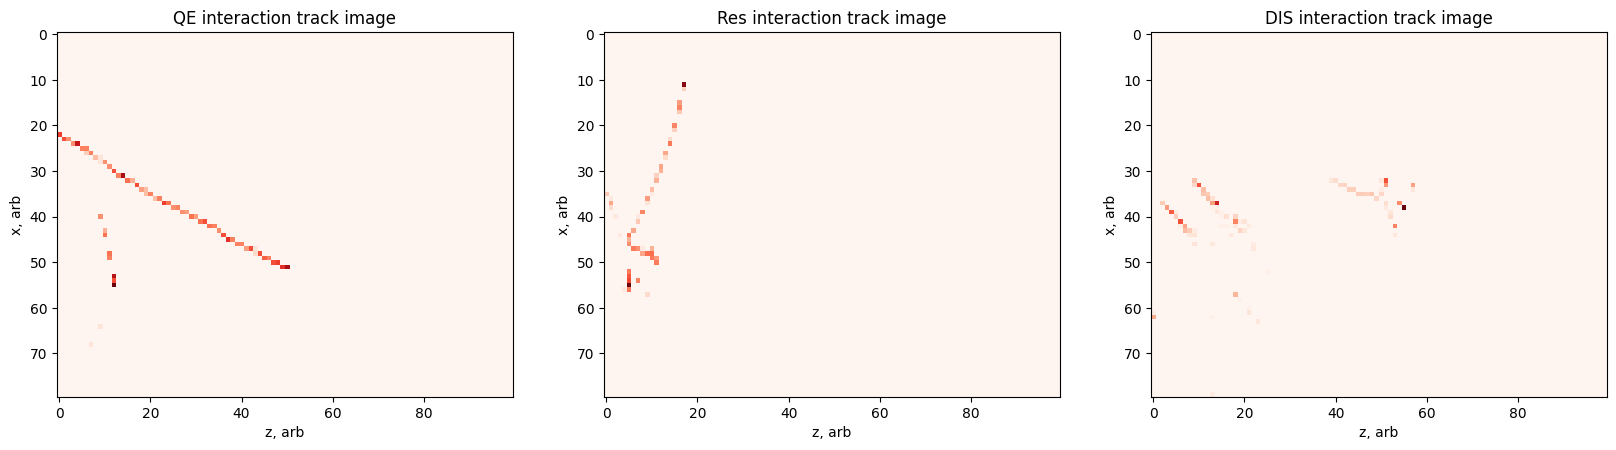

In [ ]:

# PLOTTING THE INTERACTIONS BETWEEN NEUTRINOS AND MATTER

index = 34

#Plot the event from training data
fig, ax = plt.subplots(1,3, figsize=(20,5))
im1 = ax[0].imshow(Inputs_dic['interaction'][0][index][:,:,0].T, cmap = 'Reds')
ax[0].set_title('QE interaction track image')
ax[0].set_xlabel('z, arb')
ax[0].set_ylabel('x, arb')

im2 = ax[1].imshow(Inputs_dic['interaction'][1][index][:,:,0].T, cmap = 'Reds')
ax[1].set_title('Res interaction track image')
ax[1].set_xlabel('z, arb')
ax[1].set_ylabel('x, arb')

im3 = ax[2].imshow(Inputs_dic['interaction'][2][index][:,:,0].T, cmap = 'Reds')
ax[2].set_title('DIS interaction track image')
ax[2].set_xlabel('z, arb')
ax[2].set_ylabel('x, arb')

# fig.colorbar(im1, ax= ax[0])
# fig.colorbar(im2, ax= ax[1])
# fig.colorbar(im3, ax= ax[2])
plt.show()

A simple comparison of the above images makes it clear that the QE image is the 'cleanest' as it comprises of a single line, albeit there being a spotted track to the left of the image. However, the DIS track image does not contain the line that QE had and consists of messy, spread out event tracks. The RES image is a combination of boh of these, as it consists of a straight line as well as messy tracks and showers to the left of the image.

dict_keys([0, 2, 13, 5, 1, 15, 3, 4, 6])


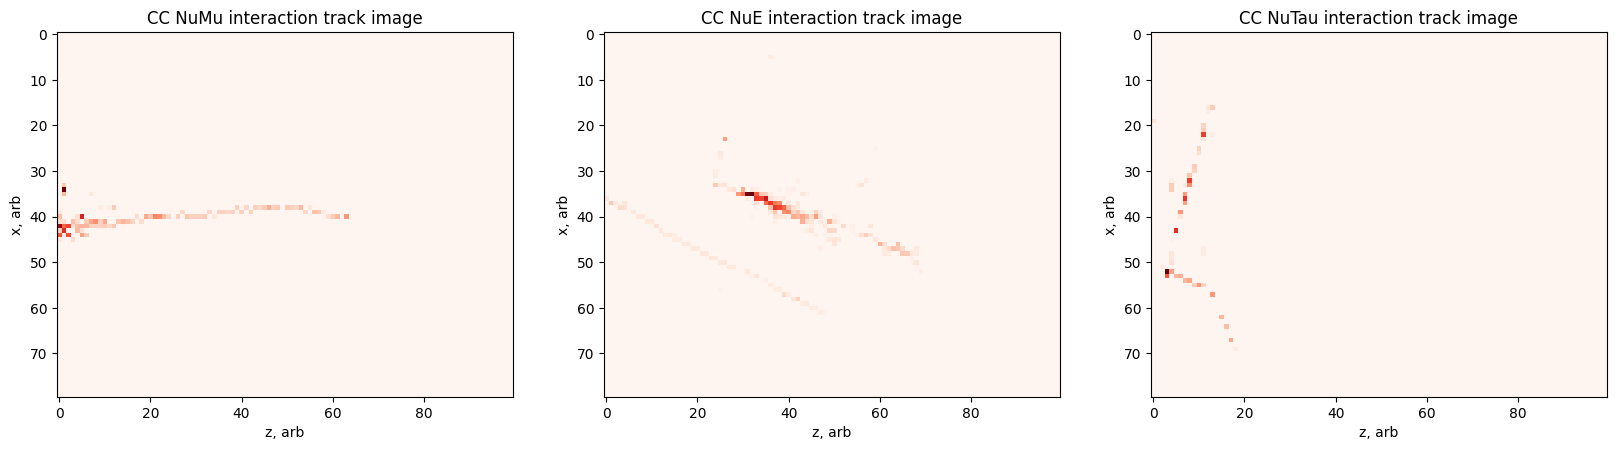

In [ ]:
index = 3
print(Inputs_dic['interaction'].keys())
#Plot the event from training data
fig, ax = plt.subplots(1,3, figsize=(20,5))
im1 = ax[0].imshow(Inputs_dic['interaction'][0][index][:,:,0].T, cmap = 'Reds')
ax[0].set_title('CC NuMu interaction track image')
ax[0].set_xlabel('z, arb')
ax[0].set_ylabel('x, arb')

im2 = ax[1].imshow(Inputs_dic['interaction'][4][index][:,:,0].T, cmap = 'Reds')
ax[1].set_title('CC NuE interaction track image')
ax[1].set_xlabel('z, arb')
ax[1].set_ylabel('x, arb')

im3 = ax[2].imshow(Inputs_dic['interaction'][13][index][:,:,0].T, cmap = 'Reds')
ax[2].set_title('CC NuTau interaction track image')
ax[2].set_xlabel('z, arb')
ax[2].set_ylabel('x, arb')

# fig.colorbar(im1, ax= ax[0])
# fig.colorbar(im2, ax= ax[1])
# fig.colorbar(im3, ax= ax[2])
plt.show()

In the above cell, we have plotted the interaction track images for CC NuMu, CC NuE and CCNuTau. Here is some information about these track images:


1.   CC NuMu (charged current (CC) interactions involving muon (NuMu)), refer to the interactions where a neutrino (or antineutrino) of the muon flavor interacts with a target nucleus, producing a muon (or antimuon) and other secondary particles. CCNuMu interactions typically produce muons, which can be detected in neutrino experiments designed to detect this flavor.
2.   CCNuE (charged current (CC) interactions involving electron (NuE)), refer to the interactions where a neutrino (or antineutrino) of the electron flavor interacts with a target nucleus, producing an electron (or positron) and other secondary particles. CCNuE interactions typically produce electrons, which can also be detected in experiments designed to detect this flavor.
3. CCNuTau (charged current (CC) interactions involving tauon (NuTau)), refer to the interactions where a neutrino (or antineutrino) of the tauon flavor interacts with a target nucleus, producing a tauon (or antitauon) and other secondary particles. CCNuTau interactions, on the other hand, produce tauons, which are relatively short-lived and decay quickly, making their detection more challenging.



Now, we shall start preparing the data to work with the tasks. Initially, we shall obtain some data files for Task 1. This project has a high number of files. However, using all the files would result in the cells taking a very long time to run as this would take a lot of RAM. In the trials of the notebook, smaller amounts of files ranging from 10-25 were used to allow the cells to run rapidly and save RAM.

In [ ]:
## Obtaining data files in task 1

files = obtaindata(10)

  0%|          | 0/10 [00:00<?, ?it/s]

The below cell reads the data from the HDF5 files containing information about neutrino interactions and extracting the labels and input images for each interaction.

In [ ]:
# Create empty arrays to store the labels (0s or 1s) and the x-z/y-z views of the neutrino interactions
neutrino_labels = []
neutrino_images_xz = []
neutrino_images_yz = []

# Iterate over the array of file names to obtain the labels and the input images for each interaction
for file_name in tqdm(files):

    # Open the file in read-only mode
    file = h5py.File(file_name, 'r')

    # Iterate over the length of cvnmap to obtain the labels and input images for each interaction
    for i in range(len(file['cvnmap'])):
        # Reshape the images
        model = file['cvnmap'][i].reshape((2, 100, 80))
        # Append the x-z view to the corresponding array
        neutrino_images_xz.append(model[0])
        # Append the y-z view to the corresponding array
        neutrino_images_yz.append(model[1])

        # Check the type of interaction and append a label (0 or 1) accordingly
        if file['neutrino']['interaction'][i] <= 3:
            neutrino_labels.append(1) # Append a 1 to the labels for muon neutrino CC events
        else:
            neutrino_labels.append(0) # Append a 0 to the labels for non-muon neutrino CC events


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
## Split the data files into train and test sets

# using 100% of the files for non muon neutrino CC events and 10% for the rest
nonmuon_files_task1, remg_files_task1 = train_test_split(files, train_size = 0.9, shuffle = False)

The below code does binary classification and balances the data for neutrino interactions. Specifically, it is using 1s to label muon neutrino CC (charged current) events and 0s to label the rest of the interactions.

If the interaction number is above 3, it is a non-neutrino CC event, and the code appends the x-z and y-z views of the interaction to the corresponding arrays and appends a 0 to the labels array. If the interaction number is below or equal to 3, it is a neutrino CC event, and the code appends the x-z and y-z views of the interaction to the corresponding arrays and appends a 1 to the labels array.

The end result is balanced data with equal numbers of neutrino and non-neutrino CC events labeled as 1s and 0s, respectively.

In [ ]:
## BINARY CLASSIFICATION AND BALANCING THE DATA
# using 1s to label muon neutrino CC events and 0s to label the rest

# empty arrays
labels= []           # Array for the labels of the neutrino interactions, either 0s or 1s
model_xz= []          # Array for the x-z view of the neutrino interaction
model_yz= []          # Array for the y-z view of the neutrino interaction


# iterating over the array of file names to obtain the lables and the input images for each interaction
for file_name in tqdm(files):

    # opening the file in read only mode
    df=h5py.File(file_name, 'r')

    # iterating over the length of cvnmap to obtain the labels and input images for each interaction
    for i in range(len(df['cvnmap'])):

      # if the interaction number is above 3 it is a non neutrino CC event
      if df['neutrino']['interaction'][i] > 3:

        model = df['cvnmap'][i].reshape((2,100,80))                 # reshaping the images
        model_xz.append(model[0])                                 # apending the x-z view to the corresponding array
        model_yz.append(model[1])                                 # apending the y-z view to the corresponding array
        labels.append(int(0))                                    # appends a 0 to the labels array for non muon neutrino CC interactions

      else:
        pass


# iterating over the array of file names to obtain the lables and the input images for each interaction
for file_name in tqdm(remg_files_task1):

    # opening the file in read only mode
    df=h5py.File(file_name, 'r')

    # iterating over the length of cvnmap to obtain the labels and input images for each interaction
    for j in range(len(df['cvnmap'])):

      # if the interaction number is below 3 it is a neutrino CC event
      if df['neutrino']['interaction'][j] <= 3:

        model = df['cvnmap'][j].reshape((2,100,80))                 # reshaping the images
        model_xz.append(model[0])                                 # apending the x-z view to the corresponding array
        model_yz.append(model[1])                                 # apending the y-z view to the corresponding array
        labels.append(int(1))                                    # appends a 1 to the labels array for muon neutrino CC interactions

      else:
        pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## PREPARING THE DATA TO BE TRAINED BY THE MODEL

# shuffling the labels and images
labels, model_xz, model_yz= shuffle_img_lbl(labels, model_xz, model_yz)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
images_xz = tf.expand_dims(model_xz, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
images_yz = tf.expand_dims(model_yz, axis = 3)

# preparing the training, testing and validation data
train_images_xz, test_images_xz, val_images_xz, train_images_yz, test_images_yz, val_images_yz, train_labels, val_labels, test_labels = prepare_data(images_xz, images_yz, labels, 0.8, 0.8)


# Task 1: $\nu_{\mu}$ Charge-Current (CC) Event Classifier

For this task, several research papers were referred and two modifications to the CNN were made, ultimately selecting one of these based on the efficiency and accuracy. Although a base CNN model was tested, this was omitted from the notebook as the modified CNN models were better, and it was decided that it was more efficient to include the models that were tested and tried by researchers.

### Multi-view CNN

A multi-view CNN (Convolutional Neural Network) model is a neural network architecture that handles data that comes from multiple views or perspectives. This model was proposed in (https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0245230).


The function create_convolution_layers creates a simple Convolutional Neural Network (CNN) model in Keras using the functional API. It takes as input an image and its shape, and returns a CNN model with three convolutional layers, max pooling layers, and dropout regularization. The first convolutional layer has 8 filters, a kernel size of (3,3), and uses the rectified linear unit (ReLU) activation function. The second and third convolutional layers have 16 and 32 filters respectively, with the same kernel size and padding as the first layer. The max pooling layers have a pool size of (2,2) and use the same padding. Dropout regularization is used to randomly exclude 25% and 40% of the data in the second and third layers respectively.

In [ ]:
def create_convolution_layers(input_img, input_shape):

  """

  This function creates a simple Convolutional Neural Network model in keras using the functional API.

  Input:
  - input_img: image to be fed into the network, either the x-z view of the interaction or the y-z view.
  - input_shape: shape of the images being fed into the network.

  Output:
  - model: CNN model

  """
  # releases the global state and helps avoid clutter from other models
  #keras.backend.clear_session


  # Conv2D layer is used for images.
  model = Conv2D(8, (3, 3),                                                     # Using a filter size of 8, kernel size of (3,3)
                 activation = "relu",                                           # Rectified Linear Unit as activation function
                 padding='same', input_shape=input_shape[1:])(input_img)        # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  # Regularization technique for the model
  model = Dropout(0.25)(model)                                                  # 25% of the data is randomly excluded


  # Conv2D layer is used for images.
  model = Conv2D(16, (3, 3),                                                    # Using a filter size of 16, kernel size of (3,3)
                 padding='same')(model)                                         # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  model = Dropout(0.25)(model)                                                  # 25% of the data is randomly excluded

  # Conv2D layer is used for images.
  model = Conv2D(16, (3, 3),                                                    # Using a filter size of 32, kernel size of (3,3)
                 padding='same')(model)                                         # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  model = Dropout(0.4)(model)                                                   # 40% of the data is randomly excluded

  return model

In [ ]:



def concatenating (model_in_1):

  """
  This function creates a simple Convolutional Neural Network model in keras using the functional API for both the views of the
  neutrino intercations, for the x-y view and the y-z view, and concatenates them.

  Input:
  - model_in_1: this is the image of the x-z view of the neutrino interaction. It is used to obtain the shape of the model input.

  Output:
  - model: CNN model of concatenated x-z and y-z views of the neutrino interactions.

  """

  # Creates the CNN model for the x-z view of the neutrino interaction.
  xz_input = Input(shape=np.shape(model_in_1)[1:])
  xz_model = create_convolution_layers(xz_input, np.shape(model_in_1)[1:])

  # Creates the CNN model for the y-z view of the neutrino interaction.
  yz_input = Input(shape=np.shape(model_in_1)[1:])
  yz_model = create_convolution_layers(yz_input, np.shape(model_in_1)[1:])

  # Concatenates the two models
  conv = concatenate([xz_model, yz_model])

  # Flattens the concatenated models
  conv = Flatten()(conv)

  # Dense layers connect all the neurons of one layer to the ones in the next layer
  dense = Dense(8,                                                              # 64 is the dimensionality of the output space
                activation = "relu")(conv)                                      # Rectified Linear Unit as activation function
  dense = Dropout(0.5)(dense)                                                   # 50% of the data is randomly excluded                                                   # 50% of the data is randomly excluded

  output = Dense(1,                                                             # 1 is the dimensionality of the output space
                 activation ="sigmoid")(dense)                                  # sigmoid as activation function.
                                                                                # The input to the function is transformed into a value between 0.0 and 1.0.

  # creates the model using the two model inputs
  model = Model(inputs = [xz_input, yz_input], outputs = [output])

  # compiles the final model
  model.compile(loss=tf.keras.losses.binary_crossentropy,                       # using binary crossentropy as a loss function as we are doing a binary classification

                optimizer='adam',                                               # adam is used for optimization algorithm for stochastic gradient descent for training deep learning models
                metrics=['accuracy'])

  model.summary()


  return model

In [ ]:
## CREATING THE MODEL FOR MUON NEUTRINO CLASSIFICATION

model_cnn = concatenating(images_xz)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 80, 8)   80          ['input_1[0][0]']                
                                                                                              

Note that when running models in this notebook, 'early stopping' is used frequently. Early stopping is a technique used when training a model to avoid overfitting and to improve the generalisation of the model. Overfitting occurs when a model is too complex, such that it starts to learn the noise and outliers in the training data, which leads to poor performance on new, unseen data.

Early stopping works by monitoring the validation loss of the model when training, which is a measure of how well the model generalises to new data that it has not encountered previously. Early stopping stops the training process at that point, before the model starts to overfit, and returns the weights of the model that gave the best validation performance.

In [ ]:
# earlystopping to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

# Training the model
history_cnn = model_cnn.fit(x=[train_images_xz,train_images_yz],y=train_labels, batch_size=64, # number of training examples utilized in one iteration
                    epochs=25,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([val_images_xz,val_images_yz],val_labels), shuffle=True,
                    callbacks =[earlystopping] )                                   # used to avoid overtraining

Epoch 1/25
143/143 [==============================] - 18s 19ms/step - loss: 0.6783 - accuracy: 0.5760 - val_loss: 0.6102 - val_accuracy: 0.7017
Epoch 2/25
143/143 [==============================] - 2s 13ms/step - loss: 0.6172 - accuracy: 0.6739 - val_loss: 0.5844 - val_accuracy: 0.7118
Epoch 3/25
143/143 [==============================] - 2s 13ms/step - loss: 0.6004 - accuracy: 0.6884 - val_loss: 0.5672 - val_accuracy: 0.7153
Epoch 4/25
143/143 [==============================] - 2s 16ms/step - loss: 0.5850 - accuracy: 0.7000 - val_loss: 0.5583 - val_accuracy: 0.7306
Epoch 5/25
143/143 [==============================] - 2s 17ms/step - loss: 0.5743 - accuracy: 0.7168 - val_loss: 0.5423 - val_accuracy: 0.7543
Epoch 6/25
143/143 [==============================] - 2s 17ms/step - loss: 0.5582 - accuracy: 0.7295 - val_loss: 0.5224 - val_accuracy: 0.7534
Epoch 7/25
143/143 [==============================] - 2s 17ms/step - loss: 0.5511 - accuracy: 0.7338 - val_loss: 0.5065 - val_accuracy: 0.770

Let us use visualkeras to obtain a clearer view of the model and its various layers.

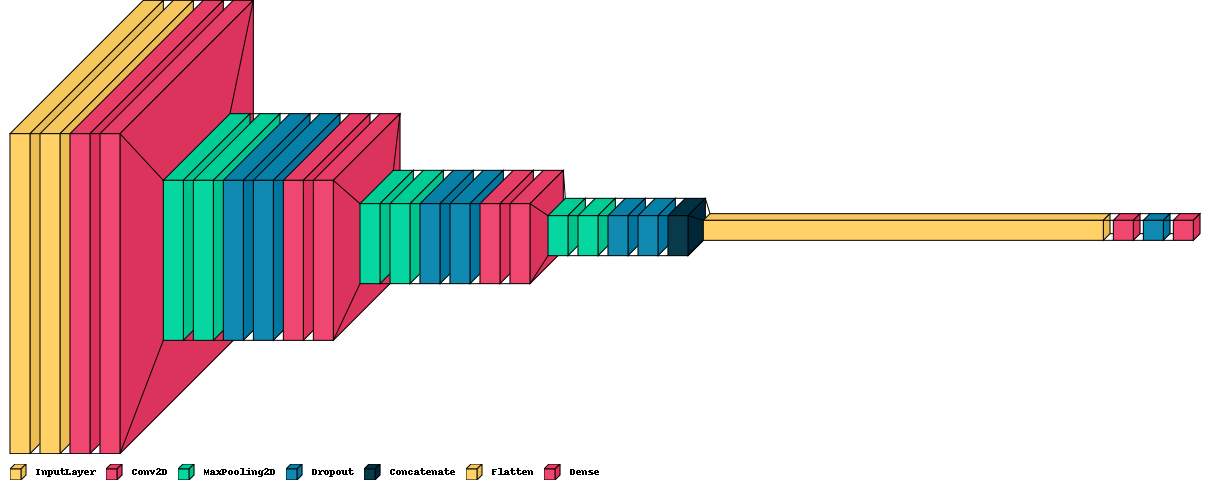

In [ ]:
visualkeras.layered_view(model_cnn, legend=True)

### Inception CNN

The Inception module is a building block in convolutional neural networks (CNNs) that was first introduced in the GoogLeNet architecture. The inception module was first proposed by C. Szegady et al [18]. This module improves the network's ability to extract imporant features from the input data by performing convolutions at multiple scales and using different filter sizes.

 The inception_module function defines a single block of the Inception architecture that takes an input layer and applies several convolutional layers of different kernel sizes and a pooling layer. The output of each convolutional layer is concatenated together and then passed on to the next layer.

The first input branch consists of several convolutional layers and pooling layers. The output of the last layer in this branch is passed to the first Inception module. Similarly, the second input branch consists of several convolutional layers and pooling layers, and its output is also passed to the first Inception module. The output of the first Inception module is passed to the second Inception module, and so on.

The output of the last Inception module is concatenated with the output of the corresponding module from the other input branch. The concatenated output is then passed through another Inception module and an average pooling layer. The output of the pooling layer is flattened and passed through a fully connected neural network with a single output node. The output node predicts a continuous value. The model takes two inputs, both of shape (100, 80, 1), and returns a single output.

Overall, the Inception module's ability to capture features at multiple scales and reduce computational complexity makes it an effective building block in CNNs for image classification and other computer vision tasks.

In [ ]:
# Setting up Inception architecture
def inception_module(layer_in, k1, k3, k5, kp):
    # 1x1 conv
    conv1 = Conv2D(k1, (1,1), padding='same', activation='relu')(layer_in)

    # 3x3 conv
    conv3 = Conv2D(k3, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(k3, (3,3), padding='same', activation='relu')(conv3)

    # 5x5 conv
    conv5 = Conv2D(k5, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(k5, (5,5), padding='same', activation='relu')(conv5)

    # Pooling
    convp = MaxPooling2D((2,2), strides = 1, padding='same')(layer_in)
    convp = Conv2D(kp, (1,1), padding='same', activation='relu')(convp)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, convp], axis=-1)

    return layer_out

####################################################################

# First input branch
x_input = Input(shape=(100, 80, 1))

# First convolutional layer of 32, 7x7 kernals; Pooling 3x3 with padding and Batch Normalisation
x_l1 = Conv2D(32, (7,7),strides= 2, padding='same', activation='relu')(x_input)
x_l2 = MaxPooling2D((3, 3),strides= 2, padding='same')(x_l1)
x_l3 = keras.layers.BatchNormalization()(x_l2)

# Second convolutional layer of 32, 1x1 kernals
x_l4 = Conv2D(32, (1,1), strides= 2, padding='same', activation='relu')(x_l3)

# Third convolutional layer of 64, 3x3 kernals
x_l5 = Conv2D(64, (3,3),strides= 2, padding='same', activation='relu')(x_l4)
x_l6 = keras.layers.BatchNormalization()(x_l5)
x_l7 = MaxPooling2D((3, 3),strides= 2, padding='same')(x_l6)

# Inception modules and pooling, kernals followed from paper above
x_l8 = inception_module(x_l7,64, 96, 16,32)
x_l9 = inception_module(x_l8, 128, 128, 32, 64)
x_l10 = MaxPooling2D((3, 3),strides= 2, padding='same')(x_l9)
x_l11 = inception_module(x_l10, 128, 128, 32, 64)

####################################################################

# Second input branch
y_input = Input(shape=(100, 80, 1))

# First convolutional layer of 32, 7x7 kernals; Pooling 3x3 with padding and Batch Normalisation
y_l1 = Conv2D(32, (7,7),strides= 2, padding='same', activation='relu')(y_input)
y_l2 = MaxPooling2D((3, 3),strides= 2, padding='same')(y_l1)
y_l3 = keras.layers.BatchNormalization()(y_l2)

# Second convolutional layer of 32, 1x1 kernals
y_l4 = Conv2D(32, (1,1), strides= 2, padding='same', activation='relu')(y_l3)

# Third convolutional layer of 64, 3x3 kernals
y_l5 = Conv2D(64, (3,3),strides= 2, padding='same', activation='relu')(y_l4)
y_l6 = keras.layers.BatchNormalization()(y_l5)
y_l7 = MaxPooling2D((3, 3),strides= 2, padding='same')(y_l6)

# Inception modules and pooling, kernals followed from paper above
y_l8 = inception_module(y_l7, 64, 96, 16, 32)
y_l9 = inception_module(y_l8, 128, 128, 32, 64)
y_l10 = MaxPooling2D((3, 3),strides= 2, padding='same')(y_l9)
y_l11 = inception_module(y_l10, 128, 128, 32, 64)

####################################################################

# Joining branches of network together
xy_l1 = concatenate([x_l11, y_l11], axis=-1)
xy_l2 = inception_module(xy_l1, 192, 96, 16, 64)
xy_l3 =  keras.layers.AveragePooling2D((6,5),padding='same')(xy_l2)

# Fully connected neural network
xy_l4 = keras.layers.Flatten()(xy_l3)
xy_l5 = keras.layers.Dense(64, activation='relu')(xy_l4)
xy_l6 = keras.layers.Dropout(0.3)(xy_l5)

# Output layer
output_layer = keras.layers.Dense(1)(xy_l6)

# Create model
inc_model = Model(inputs= (x_input, y_input), outputs=output_layer)

# Compile the network with binary crossentropy loss and adam optimiser with learning rate of 1.0
inc_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss      = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics   = [keras.metrics.BinaryAccuracy()])

inc_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 40, 32)   1600        ['input_1[0][0]']                
                                                                                              

Noticeably, the number of parameters are far higher than the Multi-View CNN. We will only be able to obtain a deeper analysis after plotting the accuracy and loss plots.

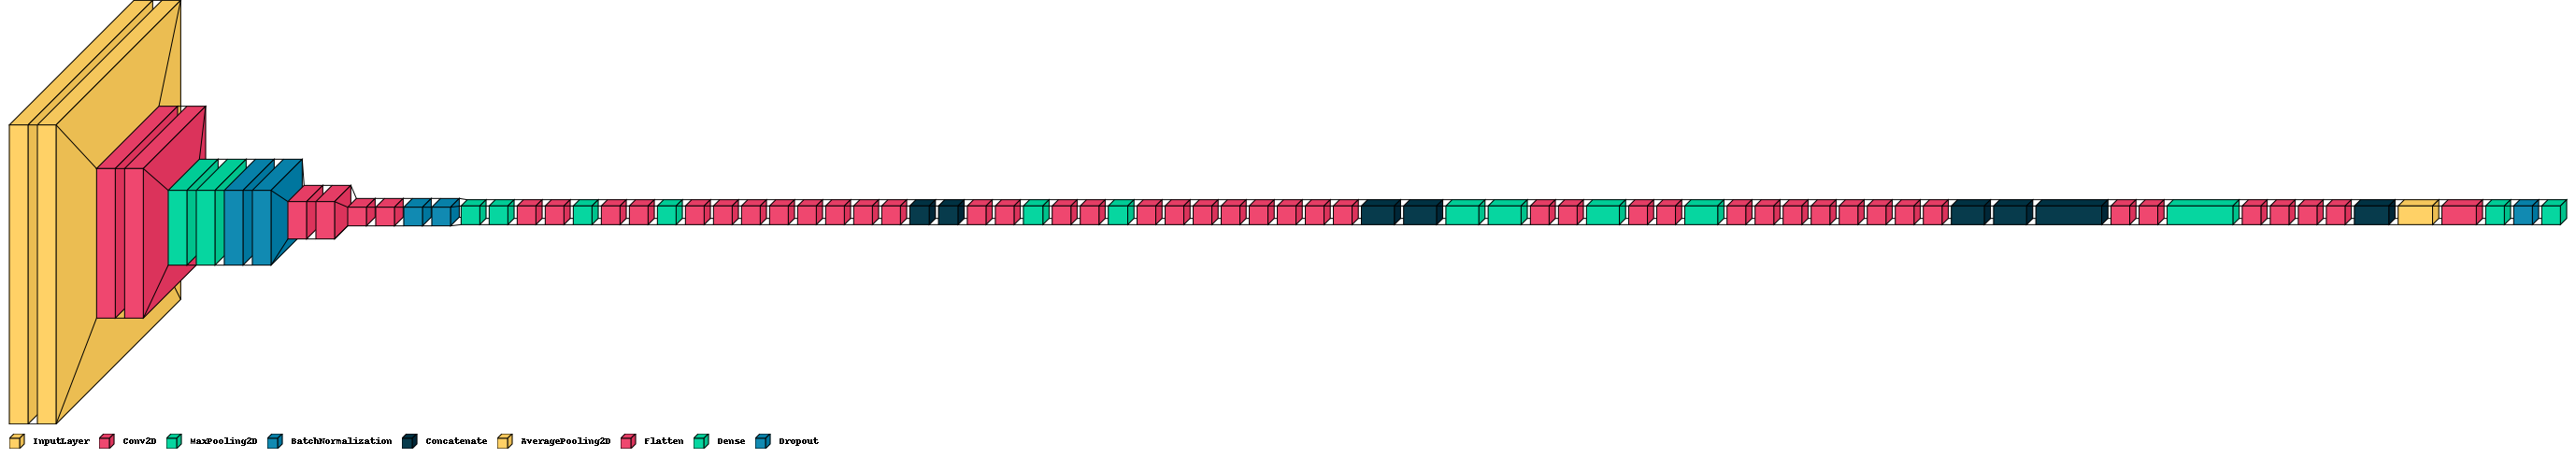

In [ ]:
# obtaining a clear visual of the model

visualkeras.layered_view(inc_model, legend=True)

In [ ]:
# using earlystopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

# training the model
inc_history = inc_model.fit(x=[train_images_xz,train_images_yz],y=train_labels, batch_size=64, # number of training examples utilized in one iteration
                    epochs=25,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([val_images_xz,val_images_yz],val_labels), shuffle=True,
                    callbacks =[earlystopping] )

Epoch 1/25
143/143 [==============================] - 37s 49ms/step - loss: 0.5104 - binary_accuracy: 0.7598 - val_loss: 0.6962 - val_binary_accuracy: 0.5664
Epoch 2/25
143/143 [==============================] - 4s 27ms/step - loss: 0.4198 - binary_accuracy: 0.8213 - val_loss: 0.6969 - val_binary_accuracy: 0.5664
Epoch 3/25
143/143 [==============================] - 4s 29ms/step - loss: 0.3819 - binary_accuracy: 0.8427 - val_loss: 0.7770 - val_binary_accuracy: 0.5664
Epoch 4/25
143/143 [==============================] - 4s 28ms/step - loss: 0.3505 - binary_accuracy: 0.8603 - val_loss: 1.4839 - val_binary_accuracy: 0.5664
Epoch 5/25
143/143 [==============================] - 4s 31ms/step - loss: 0.3296 - binary_accuracy: 0.8672 - val_loss: 1.7387 - val_binary_accuracy: 0.5664
Epoch 6/25
143/143 [==============================] - 4s 31ms/step - loss: 0.2906 - binary_accuracy: 0.8838 - val_loss: 0.5695 - val_binary_accuracy: 0.7166
Epoch 7/25
143/143 [==============================] - 4s 

---
# Task 2: Testing classifier performance and investigating how the metadata variables affect the accuracy

###How to define the performance of the classifier?

There are several ways to assess the performance of a classifier. In this task, we have used 5 main methods to determine this:




*   Accuracy and loss plots provide insights into how well the model is learning and how it is improving over time. Accuracy measures the proportion of correctly classified instances, while loss measures how well the model is able to minimize its prediction error. By monitoring these metrics during training, data scientists can detect problems with the model or its training process, such as overfitting or underfitting, and make adjustments to improve the model's performance. Additionally, accuracy and loss plots can be used to compare the performance of different models or variations of the same model.


*   The ROC curve is a suitable metric as it provides a comprehensive picture of the classifier's trade-off between sensitivity (true positive rate) and specificity (true negative rate) at different classification thresholds. An ROC curve following the diagonal line $y=x$ produces false positive and true positive results at the same rate [19]. The dashed line in Fig is known as the reference line and according to Z. Hoo et al, a  diagnostic test with appropriate accuracy is expected to have an ROC Curve in the upper left triangle [19]. As seen in Fig, the ROC curves of all the models lie in the upper left triangle above the reference line. The Area Under the Curve (AUC) provides a summary of the classifier's performance across all thresholds, where a value of 0.5 indicates random classification and 1.0 indicates perfect classification.

* Precision-recall curve: A precision-recall (PR) curve provides a visual representation of the trade-off between precision and recall for different classification thresholds in a binary classification problem. It is a useful metric because it considers the imbalance between the positive and negative classes, while remaining insensitive to changes in the class distribution. A sample precision-recall curve is shown in Fig . The values of both precision and recall range from 0 to 1 where 1 is the most ideal score. As can be seen from Fig and Fig, the curves show high precision and high recall, with the recall decreasing slowly and taking a sharp descent around 0.6.

*   Confusion matrix: The confusion matrix offers a more comprehensive evaluation of a classifier's performance. The matrix displays the number of true positives, true negatives, false positives, and false negatives in a table format. This information can be utilized to calculate several other metrics, including precision, recall, and the F1 score. The confusion matrix is particularly useful in identifying specific areas where a classifier may be struggling, such as frequent misclassification of specific instance types.



*   F1 score: The F1 score is a single numerical value that combines precision and recall, two vital metrics used to evaluate a classifier's performance. Precision measures the proportion of true positives to the total predicted positives, whereas recall is the proportion of true positives to the total actual positives. The F1 score considers both precision and recall, offering a balanced assessment of a classifier's ability to accurately recognize positive cases while minimizing false positives and false negatives. A higher F1 score suggests an improved balance between precision and recall and is, therefore, a beneficial metric for evaluating the overall performance of a classifier.






### Plot the accuracy and loss plots of Multi_View CNN


We shall use one of the functions defined earlier to obtain the accuracy and loss plots of the models which will allow us to compare their performance.

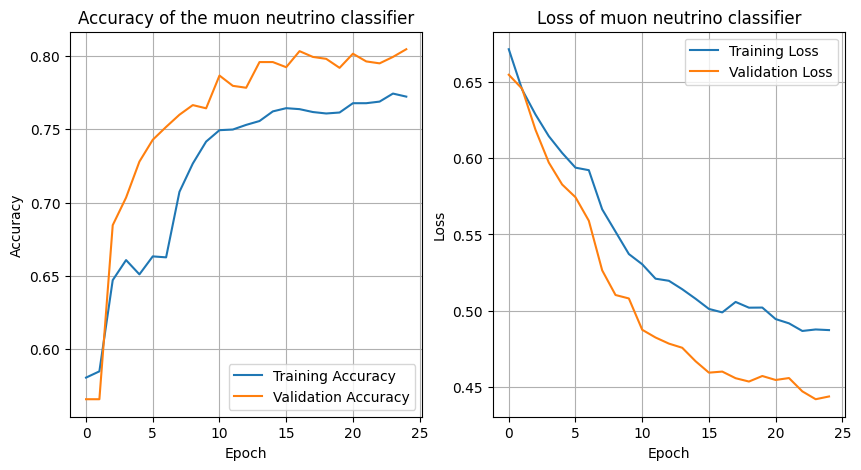

In [ ]:
# Accuracy and loss plots

plot_acc_loss(history_cnn)

The accuracy increases as the model is trained on more epochs before reaching a plateau. There are dips in the plot near an epoch of 9 and 21. The loss curve decreases as the no. of epochs increases, showing that the model is improving in its predictions. Overall, the model shows good performance.


In [ ]:
plot_acc_loss(inc_history)

The accuracy and loss plots of the inception CNN model is quite similar to the Multi-CNN model, showing overall good performance.

### Plot ROC curve for the Multi-view CNN

286/286 [==============================] - 1s 3ms/step


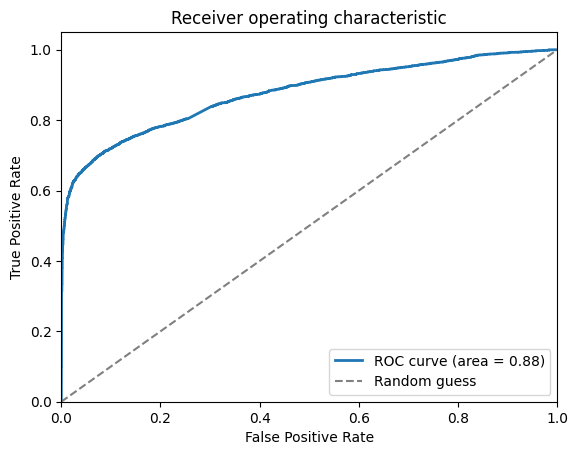

In [ ]:
# Calling the function defined earlier to plot an ROC curve

model = model_cnn
test_data = (train_images_xz,train_images_yz, train_labels)
plot_roc_curve(model, test_data)


The ROC curve shows satisfactory behaviour with a high AUC value of 0.88. This affirms the good performance of the model.

### Plot ROC curve for the Inception Module

286/286 [==============================] - 1s 2ms/step


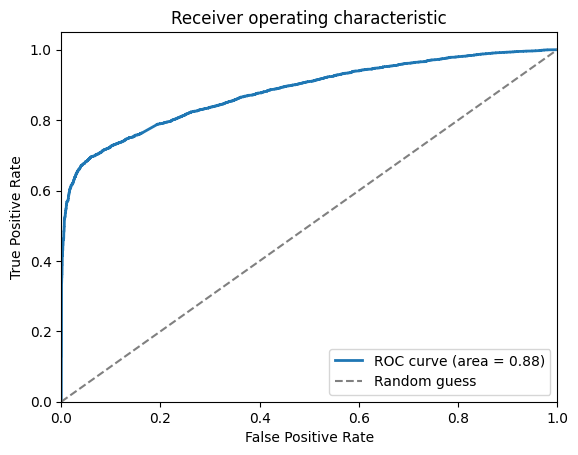

In [ ]:
# Calling the function defined earlier to plot an ROC curve

model = inc_model
test_data = (train_images_xz,train_images_yz, train_labels)
plot_roc_curve(model, test_data)

Several reruns of this code has resulted in the AUC for the inception model ranging from 0.86-0.88, which is only slightly lower than the AUC for Multi-View which has constantly stayed as 0.88. Besides this, it is crucial to consider the fact that the Multi-View model runs better than the inception model with far less parameters and taking less time. Therefore, the Multi-View CNN model shall be used from here onwards in this notebook.

### Calculating the F1 score

In [ ]:
# Calculating the F1 score

train_pred = model_cnn.predict([train_images_xz, train_images_yz])
train_pred_binary = np.round(train_pred)
f1 = f1_score(train_labels, train_pred_binary, average='binary')
print("F1 score:", f1)


286/286 [==============================] - 1s 2ms/step
F1 score: 0.7140595313489548


The F1 score proves the good performance of the model as it is quite close to 1.

### Obtaining a classification report

A classification report is a performance evaluation tool used during model training, which provides detailed information on the precision, recall, and F1-score of the model's predictions, as well as the overall accuracy. It is a useful way to assess the effectiveness of a model in classifying different categories and can assist in identifying areas where the model can be improved.

Precision is a metric that indicates the proportion of true positives to the total number of predicted positive instances, reflecting the model's capability to predict positive instances accurately.

Recall is a measure that represents the ratio of true positives to the total number of actual positive instances, indicating the model's ability to detect positive instances correctly.

The F1-score is a metric that combines precision and recall to provide a more comprehensive evaluation of a model's performance for each class. It computes the harmonic mean of precision and recall to balance their contributions to the overall performance score.

In [ ]:
# Printing out the classification report

from sklearn.metrics import classification_report

# calculate the classification report
report = classification_report(train_labels, train_pred_binary)

# print out the precision and recall values
print(report)

              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      5325
         1.0       0.90      0.59      0.71      3806

    accuracy                           0.80      9131
   macro avg       0.83      0.77      0.78      9131
weighted avg       0.82      0.80      0.79      9131



Once again, the performance is confirmed to be quite good as all the values are quite close to 1.

### Obtaining the confusion matrix
The confusion matrix offers a more comprehensive evaluation of a classifier's performance. The matrix displays the number of true positives, true negatives, false positives, and false negatives in a table format. This information can be utilized to calculate several other metrics, including precision, recall, and the F1 score. The confusion matrix is particularly useful in identifying specific areas where a classifier may be struggling, such as frequent misclassification of specific instance types. [31]

In [ ]:
# Printing the confusion matrix

train_pred = model_cnn.predict([train_images_xz, train_images_yz])
train_pred_binary = np.where(train_pred > 0.5, 1, 0) # thresholding the predicted labels

tn, fp, fn, tp = confusion_matrix(train_labels, train_pred_binary).ravel()

print("True positives:", tp)
print("False positives:", fp)
print("False negatives:", fn)
print("True negatives:", tn)

f1 = f1_score(train_labels, train_pred_binary)

print("F1 score:", f1)


286/286 [==============================] - 1s 3ms/step
True positives: 2255
False positives: 255
False negatives: 1551
True negatives: 5070
F1 score: 0.7140595313489548


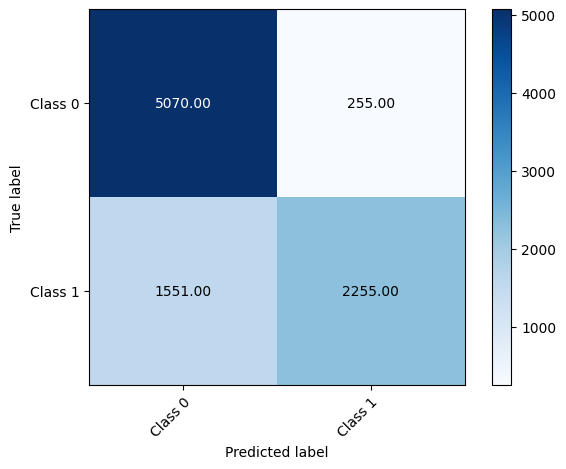

In [ ]:
# Plotting the confusion matrix for the Multi-View CNN model

train_pred_binary = (train_pred > 0.5).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(train_labels, train_pred_binary)


# plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Class 0', 'Class 1'],
       yticklabels=['Class 0', 'Class 1'],
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


## Checking if the classifier performs as well on DIS events as it does on QE events.

DIS is an acronym for Deep Inelastic Scattering. This occurs when a neutrino interacts with a nucleon inside the nucleus, producing a hadronic shower.

QE is an acronym for Quasi-Elastic Scattering. This occurs when a neutrino interacts with a single nucleon inside the nucleus, causing the nucleon to be excited to a higher energy state or to be knocked out of the nucleus entirely.

In a given dataset, DIS and QE events can be separated by their interaction codes. Events with interaction codes 0, 4, and 8 are classified as QE events, while events with interaction codes 2, 6, and 10 are classified as DIS events. We shall implement this in the function below.

## Task 2.2 Performance on CC QE and CC DIS events

Throughout the notebook, only a limited number of files are used due to computational constraints.

In [ ]:
## RETRIEVING THE FILES FOR TASK 4.2

files_t2_disqe = np.array(obtaindata(5))


  0%|          | 0/5 [00:00<?, ?it/s]

The purpose of the below code is to count the number of QE (quasi-elastic) and DIS (deep inelastic scattering) events in a dataset consisting of multiple files. It loops through each data file, opens it, and counts the number of interactions in the file. For each interaction, it checks the type of interaction by looking at the 'interaction' field in the 'neutrino' group of the HDF5 file. If the interaction is a QE event, it increments the QE counter, and if it is a DIS event, it increments the DIS counter. Finally, it returns the total number of events, as well as the number of QE and DIS events.

In [ ]:
# Count the number of QE and DIS events in the dataset
qe_count = 0       # Counter for the number of QE events
dis_count = 0      # Counter for the number of DIS events
total_events = 0   # Counter for the total number of interactions

# Loop through each data file
for file in files_t2_disqe:

    # Open the file in read-only mode
    data_file = h5py.File(file, 'r')

    # Count the number of events in the file
    num_events = len(data_file['neutrino']['interaction'])
    total_events += num_events

    # Loop through each interaction in the file
    for i in range(num_events):

        # Check the type of interaction and update the appropriate counter
        if data_file['neutrino']['interaction'][i] in [0, 4, 8]:
            # Interaction is a QE event
            qe_count += 1
        elif data_file['neutrino']['interaction'][i] in [2, 6, 10]:
            # Interaction is a DIS event
            dis_count += 1


In [ ]:
## CALCULATING THE PERCENTAGE OF QE AND DIS CC EVENTS IN THE DATASET

percent_DIS = "{:.2f}".format((dis_count / total_events)*100)                 # calculates the percentage of DIS CC events in the data
percent_QE = "{:.2f}".format((qe_count / total_events)*100)                   # calculates the percentage of QE CC events in the data

# prints the number of QE and DIS events and their corresponding percentages
print ("Number of files used:",len(files_t2_disqe), "\nTotal number of events:", total_events, "\nNumber of CC DIS events:", dis_count,
       ". This represents a ", percent_DIS, "% of the total events", "\nNumber of CC QE events: ", qe_count,
       ". This represents a", percent_QE,"% of the total events")

Number of files used: 5 
Total number of events: 34759 
Number of CC DIS events: 19097 . This represents a  54.94 % of the total events 
Number of CC QE events:  4356 . This represents a 12.53 % of the total events


There is a higher percentage of CC DIS events compared to CC QE events. Since DIS events are the messier events, this means that our classifier in Task 1 was trained predominantly on the messier events. To balance this out, we shall test the performance of the classifier in the following cases:


1.   Equal number of CC DIS and CC QE events
2.   Only CC QE events



### Testing on an equal number of CC QE and CC DIS events

In [ ]:
## SPLITTING THE DATA TO BALANCE THE LABELS AND CC DIS AND CC QE EVENTS

files_80, files_20 = train_test_split(files_t2_disqe, train_size = 0.7, shuffle = False)
files_80_disqe, files_20_disqe = train_test_split(files_20, train_size = 0.7, shuffle = False)
files_80_cc, files_20_cc = train_test_split(files_20, train_size = 0.7, shuffle = False)

The below code obtains the labels and input images for binary classification of muon neutrino charged current (CC) interactions with the matter in the detector. The code does this by iterating over a set of HDF5 files and extracting the images and labels for the interactions within those files. The images are stored in two arrays for the x-z and y-z views, and the labels are stored as either 0 (non-muon neutrino CC events) or 1 (muon neutrino CC events). Additionally, the code balances the data by iterating over the set of files and counting the number of CC QE and CC DIS events.

In [ ]:
## LABELS FOR BINARY CLASSIFICATION AND BALANCING THE DATA

# Define empty arrays to store neutrino interaction labels and images
neutrino_labels = []
disqe_xz_views = []
disqe_yz_views = []

# Counters to keep track of how many CC QE and CC DIS events there are
cc_qe_count = 0
cc_dis_count = 0

# iterating over the array of file names to obtain the labels and the input images for each interaction
for file_name in tqdm(files_t2_disqe):                                      # using 20 files

    # opening the file in read-only mode
    dataset = h5py.File(file_name, 'r')

    # iterating over the length of cvnmap to obtain the labels and input images for each interaction
    for i in range(len(dataset['cvnmap'])):

        # if the neutrino interaction number is above 3 it is a non-muon neutrino interaction
        if dataset['neutrino']['interaction'][i] > 3:

            model = dataset['cvnmap'][i].reshape((2, 100, 80))           # reshaping the images
            disqe_xz_views.append(model[0])                                    # appending the x-z view to the corresponding list
            disqe_yz_views.append(model[1])                                    # appending the y-z view to the corresponding list
            neutrino_labels.append((int(1)))                                             # assigns a 0 to non-muon neutrino CC events

        else:
            pass

# iterating over the array of file names to obtain the labels and the input images for each interaction
for file_name in tqdm(files_20):                                        # using 4 files

    # opening the file in read-only mode
    dataset = h5py.File(file_name, 'r')

    # iterating over the length of cvnmap to obtain the labels and input images for each interaction
    for j in range(len(dataset['cvnmap'])):

        # if the interaction number is 0 it is a muon neutrino CC QE event
        if dataset['neutrino']['interaction'][j] == 0:

            model = dataset['cvnmap'][j].reshape((2, 100, 80))           # reshaping the images
            disqe_xz_views.append(model[0])                                    # appending the x-z view to the corresponding list
            disqe_yz_views.append(model[1])                                    # appending the y-z view to the corresponding list
            neutrino_labels.append(1)                                             # assigns 1 to muon neutrino CC events
            cc_qe_count += 1                                              # increment QE counter

        else:
            pass


# iterating over the array of file names to obtain the lables and the input images for each interaction
for file_name in tqdm(files_20_disqe):                                        # using 1 files

  # opening the file in read only mode
  dataset=h5py.File(file_name, 'r')

  # iterating over the length of cvnmap to obtain the labels and input images for each interaction
  for z in range(len(dataset['cvnmap'])):

    # if the neutrino interaction number is equal or below 3 it is a muon neutrino CC event
    if dataset['neutrino']['interaction'][z] <= 3:

      model = (dataset['cvnmap'][z]).reshape((2,100,80))                       # reshaping the images
      disqe_xz_views.append(model[0])                                # apending the x-z view to the corresponding array
      disqe_yz_views.append(model[1])                                # apending the y-z view to the corresponding array
      neutrino_labels.append(int(1))                                   # assigns 1 to muon neutrino CC events

      # is the neutrino interaction number is 0 it is a QE event
      if (dataset['neutrino']['interaction'][z]) == 0:
        cc_qe_count = cc_qe_count + 1

      # is the neutrino interaction number is 0 it is a DIS event
      elif (dataset['neutrino']['interaction'][z]) == 2:

        cc_dis_count = cc_dis_count + 1

    else:
      pass

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

This code also works similarly as the before cell by defining empty arrays to store information about neutrino interactions and their associated images and then iterating over multiple files to obtain labels and input images for each neutrino interaction.  

In [ ]:
# Define empty arrays to store neutrino interaction labels and images
neutrino_labels = []
disqe_xz_views = []
disqe_yz_views = []

# Counters to keep track of how many CC QE and CC DIS events there are
cc_qe_count = 0
cc_dis_count = 0

# iterating over the array of file names to obtain the labels and the input images for each interaction
for file_name in tqdm(files_t2_disqe):                                      # using 20 files

    # opening the file in read-only mode
    dataset = h5py.File(file_name, 'r')

    # iterating over the length of cvnmap to obtain the labels and input images for each interaction
    for i in range(len(dataset['cvnmap'])):

        # if the neutrino interaction number is above 3 it is a non-muon neutrino interaction
        if dataset['neutrino']['interaction'][i] > 3:

            model = dataset['cvnmap'][i].reshape((2, 100, 80))           # reshaping the images
            disqe_xz_views.append(model[0])                                    # appending the x-z view to the corresponding list
            disqe_yz_views.append(model[1])                                    # appending the y-z view to the corresponding list
            neutrino_labels.append(0)                                             # assigns a 0 to non-muon neutrino CC events

        else:
            pass

# iterating over the array of file names to obtain the labels and the input images for each interaction
for file_name in tqdm(files_20):                                        # using 4 files

    # opening the file in read-only mode
    dataset = h5py.File(file_name, 'r')

    # iterating over the length of cvnmap to obtain the labels and input images for each interaction
    for j in range(len(dataset['cvnmap'])):

        # if the interaction number is 0 it is a muon neutrino CC QE event
        if dataset['neutrino']['interaction'][j] == 0 and cc_qe_count < cc_dis_count:

            model = dataset['cvnmap'][j].reshape((2, 100, 80))           # reshaping the images
            disqe_xz_views.append(model[0])                                    # appending the x-z view to the corresponding list
            disqe_yz_views.append(model[1])                                    # appending the y-z view to the corresponding list
            neutrino_labels.append(1)                                             # assigns 1 to muon neutrino CC events
            cc_qe_count += 1                                              # increment QE counter

        # if the interaction number is 2 it is a muon neutrino CC DIS event
        elif dataset['neutrino']['interaction'][j] == 2 and cc_dis_count < cc_qe_count:

            model = dataset['cvnmap'][j].reshape((2, 100, 80))           # reshaping the images
            disqe_xz_views.append(model[0])                                    # appending the x-z view to the corresponding list
            disqe_yz_views.append(model[1])                                    # appending the y-z view to the corresponding list
            neutrino_labels.append(1)                                             # assigns 1 to muon neutrino CC events
            cc_dis_count += 1                                              # increment DIS counter

        else:
            pass


# iterating over the array of file names to obtain the lables and the input images for each interaction
for file_name in tqdm(files_20_disqe):                                        # using 1 files

  # opening the file in read only mode
  dataset=h5py.File(file_name, 'r')

  # iterating over the length of cvnmap to obtain the labels and input images for each interaction
  for z in range(len(dataset['cvnmap'])):

    # if the neutrino interaction number is equal or below 3 it is a muon neutrino CC event
    if dataset['neutrino']['interaction'][z] <= 3:

      model = (dataset['cvnmap'][z]).reshape((2,100,80))                       # reshaping the images
      disqe_xz_views.append(model[0])                                # apending the x-z view to the corresponding array
      disqe_yz_views.append(model[1])                                # apending the y-z view to the corresponding array
      neutrino_labels.append(int(1))                                   # assigns 1 to muon neutrino CC events

      # is the neutrino interaction number is 0 it is a QE event
      if (dataset['neutrino']['interaction'][z]) == 0:
        cc_qe_count = cc_qe_count + 1

      # is the neutrino interaction number is 0 it is a DIS event
      elif (dataset['neutrino']['interaction'][z]) == 2:

        cc_dis_count = cc_dis_count + 1

    else:
      pass




  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# shuffling the labels and images
neutrino_labels, disqe_xz_views, disqe_yz_views = shuffle_img_lbl(neutrino_labels, disqe_xz_views, disqe_yz_views)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
disqe_xz_views = tf.expand_dims(disqe_xz_views, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
disqe_yz_views = tf.expand_dims(disqe_yz_views, axis = 3)

# preparing the training, testing and validation data
disqe_eq_train_input_xz, disqe_eq_test_input_xz, disqe_eq_val_input_xz, disqe_eq_train_input_yz, disqe_eq_test_input_yz, disqe_eq_val_input_yz, disqe_eq_train_labels, disqe_eq_val_labels, disqe_eq_test_labels = prepare_data(disqe_xz_views, disqe_xz_views, neutrino_labels,0.8,0.8)


In [ ]:
## CREATING THE MODEL FOR MUON NEUTRINO CLASSIFICATION

model_eq = concatenating(disqe_xz_views)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 80, 8)   80          ['input_3[0][0]']                
                                                                                            

In [ ]:
# earlystopping to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

# training the model
history_high_e = model_eq.fit(x=[disqe_eq_train_input_xz, disqe_eq_train_input_yz],
                    y=disqe_eq_train_labels, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([disqe_eq_val_input_xz, disqe_eq_val_input_yz],disqe_eq_val_labels),
                    callbacks =[earlystopping] )

Epoch 1/50
101/101 [==============================] - 5s 20ms/step - loss: 0.6655 - accuracy: 0.6162 - val_loss: 0.6114 - val_accuracy: 0.6716
Epoch 2/50
101/101 [==============================] - 1s 13ms/step - loss: 0.6236 - accuracy: 0.6550 - val_loss: 0.5895 - val_accuracy: 0.6878
Epoch 3/50
101/101 [==============================] - 1s 13ms/step - loss: 0.6163 - accuracy: 0.6651 - val_loss: 0.5680 - val_accuracy: 0.7089
Epoch 4/50
101/101 [==============================] - 1s 13ms/step - loss: 0.6074 - accuracy: 0.6719 - val_loss: 0.5628 - val_accuracy: 0.7039
Epoch 5/50
101/101 [==============================] - 1s 13ms/step - loss: 0.5966 - accuracy: 0.6763 - val_loss: 0.5625 - val_accuracy: 0.7107
Epoch 6/50
101/101 [==============================] - 1s 13ms/step - loss: 0.5853 - accuracy: 0.6917 - val_loss: 0.5477 - val_accuracy: 0.7244
Epoch 7/50
101/101 [==============================] - 1s 13ms/step - loss: 0.5741 - accuracy: 0.7021 - val_loss: 0.5290 - val_accuracy: 0.7219

In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL
test_loss_eq, test_acc_eq = model_eq.evaluate([disqe_eq_test_input_xz, disqe_eq_test_input_yz], disqe_eq_test_labels, verbose=2)


63/63 - 0s - loss: 0.4574 - accuracy: 0.7705 - 437ms/epoch - 7ms/step


The model is performing quite well with an accuracy of 0.79 and loss of 0.45.

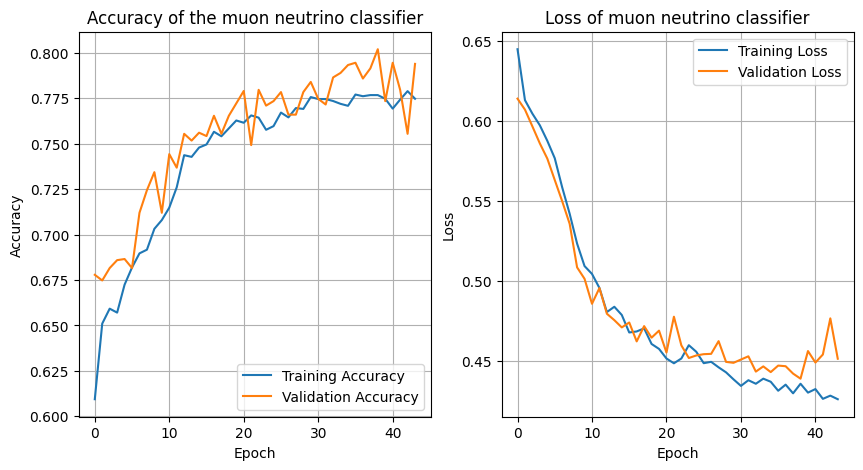

In [ ]:
# Acccuracy and loss plots

plot_acc_loss(history_high_e)

The accuracy and loss plots show good performance of the model without any overfitting. However, there are noticeable fluctuations, that could be caused by noisy data.

63/63 [==============================] - 5s 74ms/step


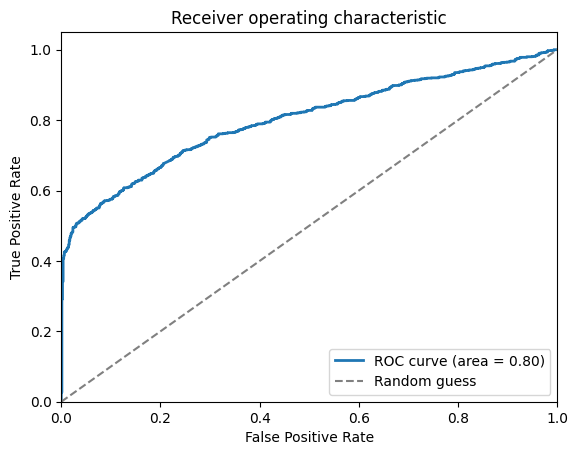

In [ ]:
# Plotting the ROC curve

test_data = disqe_eq_test_input_xz, disqe_eq_test_input_yz, disqe_eq_test_labels
plot_roc_curve(model_cnn, test_data)

The ROC curve lies in the upper left triangle and performs well, although the curve is not quite smooth. This could be due to the limited data used. However, this was a compromised decision in order to not use up too much RAm and slow down the running of the notebook. The AUC also has an acceptable value of 0.80.

202/202 [==============================] - 1s 3ms/step


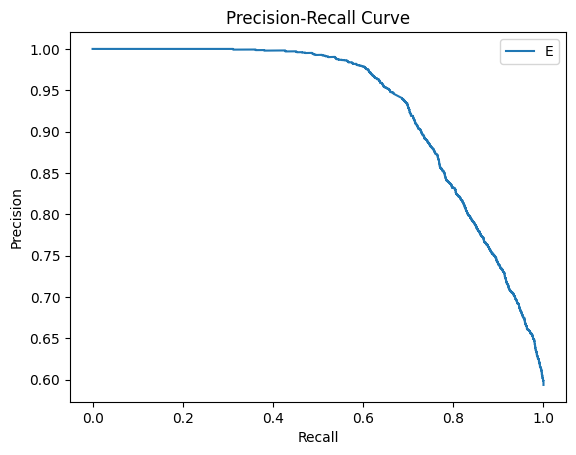

In [ ]:
from sklearn.metrics import precision_recall_curve
# generate predictions for the test dataset
y_pred = model_eq.predict([disqe_eq_train_input_xz, disqe_eq_train_input_yz])

# calculate precision and recall for different thresholds
precision_disqe_eq, recall_disqe_eq, thresholds = precision_recall_curve(disqe_eq_train_labels, y_pred)

# plot the precision-recall curve
plt.plot(recall_disqe_eq, precision_disqe_eq)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend('Equal no. of CC QE and CC DIS events')
plt.title('Precision-Recall Curve')
plt.show()

The model shows good performance with performance and recall values of 1.0,  indicating that the model is able to accurately classify positive and negative samples.

In [ ]:
# Obtaining a classification report

train_pred = model_eq.predict([disqe_eq_train_input_xz, disqe_eq_train_input_yz])
train_pred_binary = np.round(train_pred)
f1 = f1_score(disqe_eq_train_labels, train_pred_binary, average='binary')
print("F1 score:", f1)
from sklearn.metrics import classification_report


# calculate the classification report
report = classification_report(disqe_eq_train_labels, train_pred_binary)

# print out the precision and recall values
print(report)

202/202 [==============================] - 1s 3ms/step
F1 score: 0.8008485812781756
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72      2591
         1.0       0.82      0.78      0.80      3850

    accuracy                           0.77      6441
   macro avg       0.76      0.76      0.76      6441
weighted avg       0.77      0.77      0.77      6441



The classification report also shows high values close to 1.0, showing satisfactory performance.

## Performance of classifier on a dataset with only CC QE events

In [ ]:
## SPLITTING THE DATA TO BALANCE THE LABELS AND CC DIS AND CC QE EVENTS

files_80, files_20 = train_test_split(files_t2_disqe, train_size = 0.7, shuffle = False)
files_80_cc, files_20_cc = train_test_split(files_20, train_size = 0.7, shuffle = False)

In [ ]:

## LABELS FOR BINARY CLASSIFICATION AND BALANCING THE DATA
# Using 1s to label electron neutrino CC events and 0s to label the rest
# Only using CC QE events

labels_qe = []    # empty array for the labels of the neutrino interactions, either 0s or 1s
xz_views_qe = [] # empty array for the x-z view of the neutrino interaction
yz_views_qe = [] # empty array for the y-z view of the neutrino interaction
qe_count = 0    # counter to keep track of how many CC QE events there are
dis_count = 0

# Iterating over the loaded data files to obtain the number of each type of events
for f_name in tqdm(files_t2_disqe): # using 20 files

  # Opening the file in read mode only
  with h5py.File(f_name, 'r') as df:

    # Iterating over the length of neutrino interactions in the data file
    for i in range(len(df['cvnmap'])):

      # If the neutrino interaction number is higher than 3, it is a non-muon neutrino event
      if df['neutrino']['interaction'][i] > 3:

          model = (df['cvnmap'][i]).reshape((2,100,80)) # reshaping the images
          xz_views_qe.append(model[0]) # Appending the x-z view to the corresponding array
          yz_views_qe.append(model[1]) # Appending the y-z view to the corresponding array
          labels_qe.append(int(0)) # Assigns a 0 to non muon neutrino CC events

      else:
        pass

# Iterating over the loaded data files to obtain the number of each type of events
for f_name in tqdm(files_t2_disqe[:4]): # using 4 files

  # Opening the file in read mode only
  with h5py.File(f_name, 'r') as df:

    # Iterating over the length of images in the data file
    for j in range(len(df['cvnmap'])):

      # If the neutrino interaction corresponds to 0 it is a muon neutrino CC QE event
      if df['neutrino']['interaction'][j] == 0:

        model = (df['cvnmap'][j]).reshape((2,100,80)) # reshaping the images
        xz_views_qe.append(model[0]) # Appending the x-z view to the corresponding array
        yz_views_qe.append(model[1]) # Appending the y-z view to the corresponding array
        labels_qe.append(int(1)) # Assigns 1 to muon neutrino CC events

        qe_count += 1

      else:
        pass


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# shuffling the labels and images
labels_qe, xz_views_qe, yz_views_qe = shuffle_img_lbl(labels_qe, xz_views_qe, yz_views_qe)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
xz_views_qe = tf.expand_dims(xz_views_qe, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
yz_views_qe = tf.expand_dims(yz_views_qe, axis = 3)

# preparing the training, testing and validation data
train_images_xz_qe, test_images_xz_qe, val_images_xz_qe, train_images_yz_qe, test_images_yz_qe, val_images_yz_qe, train_labels_qe, val_labels_qe, test_labels_qe = prepare_data(xz_views_qe, yz_views_qe, labels_qe, 0.8, 0.8)


In [ ]:

## CREATING THE MODEL FOR ELECTRON NEUTRINO CLASSIFICATION

model_qe = concatenating(xz_views_qe)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 100, 80, 8)   80          ['input_5[0][0]']                
                                                                                            

In [ ]:
# earlystopping to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

# training the model
history_qe = model_qe.fit(x=[train_images_xz_qe, train_images_yz_qe],
                    y=train_labels_qe, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([val_images_xz_qe, val_images_yz_qe], val_labels_qe,),
                    callbacks =[earlystopping] )

Epoch 1/50
76/76 [==============================] - 5s 24ms/step - loss: 0.6893 - accuracy: 0.5397 - val_loss: 0.6774 - val_accuracy: 0.5415
Epoch 2/50
76/76 [==============================] - 1s 14ms/step - loss: 0.6402 - accuracy: 0.6005 - val_loss: 0.5577 - val_accuracy: 0.7504
Epoch 3/50
76/76 [==============================] - 1s 13ms/step - loss: 0.6025 - accuracy: 0.6405 - val_loss: 0.5244 - val_accuracy: 0.7794
Epoch 4/50
76/76 [==============================] - 1s 13ms/step - loss: 0.5988 - accuracy: 0.6486 - val_loss: 0.5136 - val_accuracy: 0.7844
Epoch 5/50
76/76 [==============================] - 1s 13ms/step - loss: 0.5920 - accuracy: 0.6571 - val_loss: 0.5008 - val_accuracy: 0.7944
Epoch 6/50
76/76 [==============================] - 1s 13ms/step - loss: 0.5724 - accuracy: 0.6573 - val_loss: 0.4711 - val_accuracy: 0.7935
Epoch 7/50
76/76 [==============================] - 1s 13ms/step - loss: 0.5614 - accuracy: 0.6764 - val_loss: 0.4812 - val_accuracy: 0.7985
Epoch 8/50
76

In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL

test_loss_cc, test_acc_cc = model_qe.evaluate([test_images_xz_qe, test_images_yz_qe],  test_labels_qe, verbose=2)


48/48 - 0s - loss: 0.2867 - accuracy: 0.8839 - 252ms/epoch - 5ms/step


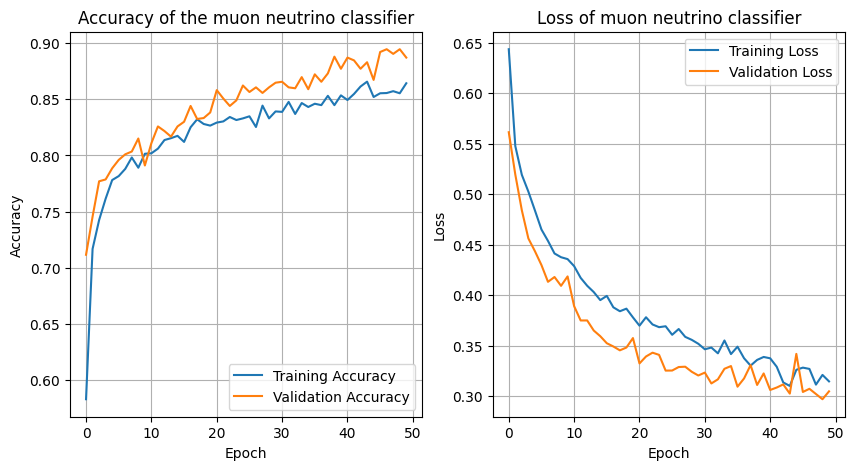

In [ ]:
# obtaining accuracy and loss plots

plot_acc_loss(history_qe)

The plots show overall good performance, although there are noticeable fluctuations after epoch 10. This could be due to noisy data or small batch size. With regards to small batch size, generalising will be difficult, leading to inconsistent results which could cause the fluctuations.

48/48 [==============================] - 3s 64ms/step


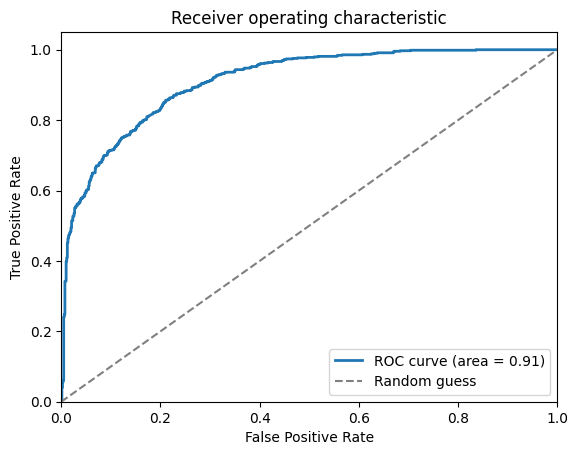

In [ ]:
# Plotting ROC curve

test_data = test_images_xz_qe, test_images_yz_qe, test_labels_qe
plot_roc_curve(model_qe, test_data)

Despite earlier concerns regarding the fluctuations of the accuracy and loss plots, the AUC is quite high with a value of 0.91, affirming the good performance of the model on the dataset.

151/151 [==============================] - 0s 2ms/step


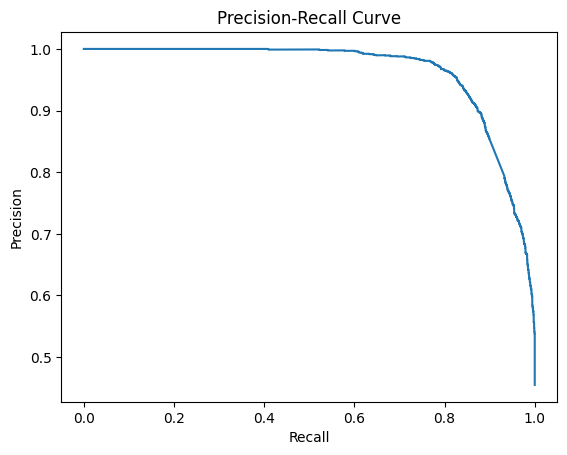

In [ ]:
from sklearn.metrics import precision_recall_curve
# generate predictions for the test dataset
y_pred = model_qe.predict([train_images_xz_qe, train_images_yz_qe])

# calculate precision and recall for different thresholds
precision_qe, recall_qe, thresholds = precision_recall_curve(train_labels_qe, y_pred)

# plot the precision-recall curve
plt.plot(recall_qe, precision_qe)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

The precision recall curve also shows good performance with the precision declining steeply after a recall value of 0.8. However, there is a noticeable dip in the beginning at a recall value of around 0.0. This could indicate that there are a relatively large number of false positives early on in the predictions.

In [ ]:
# Obtaining classification report

train_pred = model_eq.predict([train_images_xz_qe, train_images_yz_qe])
train_pred_binary = np.round(train_pred)
f1 = f1_score(train_labels_qe, train_pred_binary, average='binary')
print("F1 score:", f1)
from sklearn.metrics import classification_report


# calculate the classification report
report = classification_report(train_labels_qe, train_pred_binary)

# print out the precision and recall values
print(report)


151/151 [==============================] - 0s 2ms/step
F1 score: 0.774807614418793
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.76      2617
         1.0       0.70      0.87      0.77      2204

    accuracy                           0.77      4821
   macro avg       0.78      0.78      0.77      4821
weighted avg       0.79      0.77      0.77      4821



### Task 2.3 How well does the classifier perform on low energy neutrinos vs high energy neutrinos?

#### Testing performance only on high energy neutrinos

In [ ]:
## RETRIEVING THE FILES FOR THIS SECTION

files_t2_3=obtaindata(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
## SPLITTING THE FILES TO BE ABLE TO BALANCE THE LABELS

files_80_qe, files_20_qe = train_test_split(files_t2_3, train_size = 0.9, shuffle = False)

In [ ]:
## SETTING THE THRESHOLD FOR HIGH/LOW ENERGY NEUTRINO

threshold = 3.5

In [ ]:
high_e_labels=[]                                                           # empty array to store the labels, 1 for muon neutrino events and 0 for the rest
high_e_xz_views=[]                                                          # empty array for the x-z view of the neutrino interaction
high_e_yz_views=[]

# iterating over the loaded data files to obtain the number of each type of events
for filename in tqdm(files_t2_3):

  # opening the file in read mode only
  df=df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions in the data file
  for i in range(len(df['neutrino']['interaction'])):

    # only classifying those neutrino with energy above the threshold
    if (df['neutrino']['nuenergy'][i]) > threshold:

      # if the neutrino interaction number is above 3 it is a non-muon neutrino CC event
      if (df['neutrino']['interaction'][i]) > 3:
        model = (df['cvnmap'][i]).reshape((2,100,80))                     # reshaping the images
        high_e_xz_views.append(model[0])                                   # apending the x-z view to the corresponding array
        high_e_yz_views.append(model[1])                                   # apending the y-z view to the corresponding array
        high_e_labels.append(int(0))                                      # 0 for non muon neutrino CC events

      else:
        pass

# iterating over the loaded data files to obtain the number of each type of events
for filename in tqdm(files_20_qe):

  # opening the file in read mode only
  df=df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions in the data file
  for j in range(len(df['neutrino']['interaction'])):

    # only classifying those neutrino with energy above the threshold
    if (df['neutrino']['nuenergy'][j]) > threshold:

      # if the neutrino interaction number is below or equal to 3 it is a muon neutrino CC event
      if (df['neutrino']['interaction'][j]) <= 3:

        model = (df['cvnmap'][j]).reshape((2,100,80))                     # reshaping the images
        high_e_xz_views.append(model[0])                                   # apending the x-z view to the corresponding array
        high_e_yz_views.append(model[1])                                   # apending the y-z view to the corresponding array
        high_e_labels.append(int(1))                                      # 1 for non muon neutrino CC events

      else:
        pass

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# shuffling the labels and images
high_e_labels, high_e_input_xz, high_e_input_yz = shuffle_img_lbl(high_e_labels, high_e_xz_views, high_e_yz_views)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
high_e_xz_views = tf.expand_dims(high_e_xz_views, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
high_e_yz_views = tf.expand_dims(high_e_yz_views, axis = 3)

# preparing the training, testing and validation data
high_e_train_images_xz, high_e_test_images_xz, high_e_val_images_xz, high_e_train_images_yz, high_e_test_images_yz, high_e_val_images_yz, high_e_train_labels, high_e_val_labels, high_e_test_labels = prepare_data(high_e_xz_views, high_e_yz_views, high_e_labels, 0.8, 0.8)

In [ ]:
## CREATING THE MODEL FOR ELECTRON NEUTRINO CLASSIFICATION
model_high_neu = concatenating(high_e_xz_views)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 80, 8)   80          ['input_3[0][0]']                
                                                                                            

In [ ]:
# earlystopping to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

# training the model
history_high_e = model_high_neu.fit(x=[high_e_train_images_xz, high_e_train_images_yz],
                    y=high_e_train_labels, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([high_e_val_images_xz,high_e_val_images_yz],high_e_val_labels),
                    callbacks =[earlystopping] )

Epoch 1/50
64/64 [==============================] - 5s 25ms/step - loss: 0.6822 - accuracy: 0.5974 - val_loss: 0.6688 - val_accuracy: 0.6104
Epoch 2/50
64/64 [==============================] - 1s 14ms/step - loss: 0.6760 - accuracy: 0.5989 - val_loss: 0.6798 - val_accuracy: 0.6104
Epoch 3/50
64/64 [==============================] - 1s 13ms/step - loss: 0.6771 - accuracy: 0.5989 - val_loss: 0.6693 - val_accuracy: 0.6104
Epoch 4/50
64/64 [==============================] - 1s 13ms/step - loss: 0.6780 - accuracy: 0.5989 - val_loss: 0.6752 - val_accuracy: 0.6104
Epoch 5/50
64/64 [==============================] - 1s 13ms/step - loss: 0.6788 - accuracy: 0.5989 - val_loss: 0.6704 - val_accuracy: 0.6104
Epoch 6/50
64/64 [==============================] - 1s 14ms/step - loss: 0.6762 - accuracy: 0.5989 - val_loss: 0.6761 - val_accuracy: 0.6104


In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL

test_loss, test_acc = model_high_neu.evaluate([test_images_xz,test_images_yz],  test_labels, verbose=2)

90/90 - 1s - loss: 0.7475 - accuracy: 0.4138 - 586ms/epoch - 7ms/step


The accuracy is much lower than expected with a comparatively high loss as well.

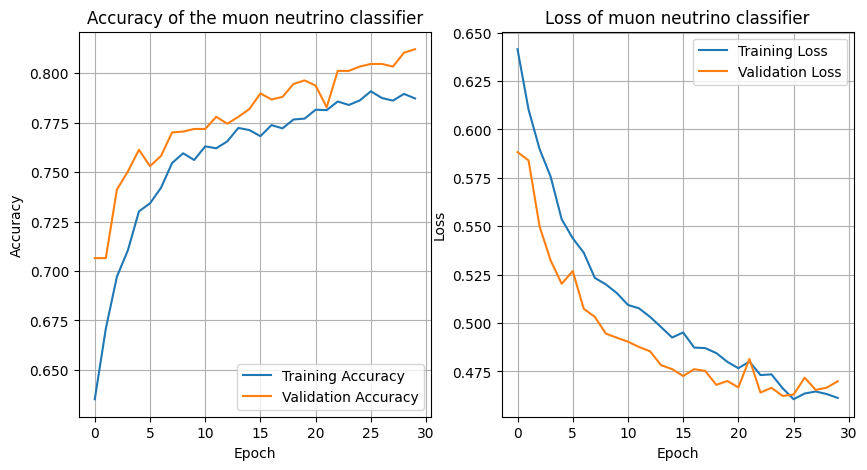

In [ ]:
# Accuracy and loss plots

plot_acc_loss(history_high_e)

90/90 [==============================] - 0s 3ms/step


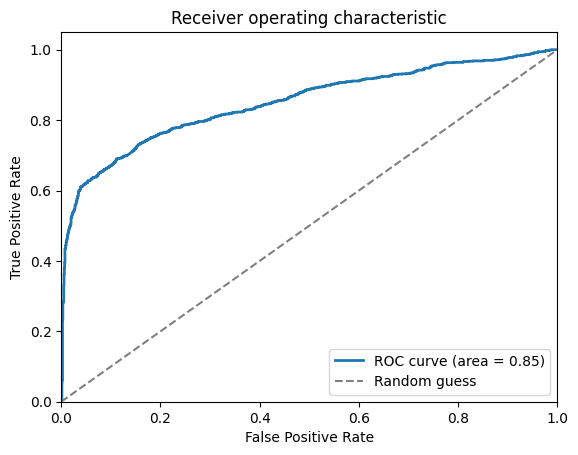

In [ ]:
# Plotting ROC curve

test_data = test_images_xz, test_images_yz, test_labels
plot_roc_curve(model_cnn, test_data)

128/128 [==============================] - 0s 2ms/step


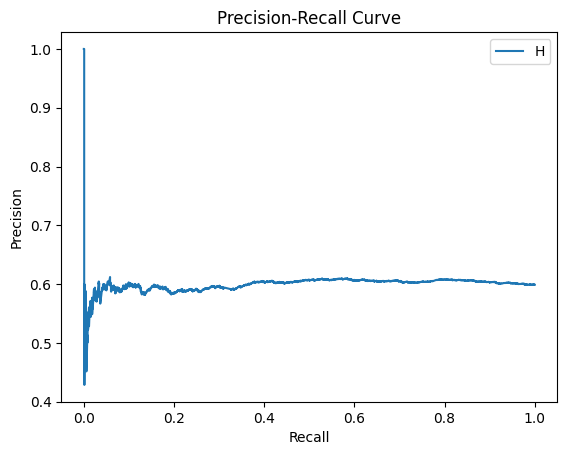

In [ ]:
# generate predictions for the test dataset
y_pred = model_eq.predict([high_e_train_images_xz, high_e_train_images_yz])

# calculate precision and recall for different thresholds
precision_high_neu, recall_high_neu, thresholds = precision_recall_curve(high_e_train_labels, y_pred)

# plot the precision-recall curve
plt.plot(recall_high_neu, precision_high_neu)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend('High energy neutrinos')
plt.title('Precision-Recall Curve')
plt.show()

This precision-recall curve is not similar to the ones plotted before. There are initial fluctuations until a recall value of 0.1 after which there is a straight line. This could be due to a data imbalance. Another reason could be a constant threshold. If the threshold for classifying examples as positive or negative is fixed, the precision-recall curve will be a horizontal line.

In [ ]:
train_pred = model_high_neu.predict([high_e_train_images_xz, high_e_train_images_yz])
train_pred_binary = np.round(train_pred)
f1 = f1_score(high_e_train_labels, train_pred_binary, average='binary')
print("F1 score:", f1)
from sklearn.metrics import classification_report


# calculate the classification report
report = classification_report(high_e_train_labels, train_pred_binary)

# print out the precision and recall values
print(report)


128/128 [==============================] - 1s 4ms/step
F1 score: 0.7491556647221369
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1634
         1.0       0.60      1.00      0.75      2440

    accuracy                           0.60      4074
   macro avg       0.30      0.50      0.37      4074
weighted avg       0.36      0.60      0.45      4074



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report shows values that are much lower than the values obtained before. This shows the poor performance of the model on this particular dataset, confirming that this could be due to imbalanced data or constant threshold.

## Testing performance on low energy neutrinos

The coding structure will be similar to what has been done so far.

In [ ]:
## RETRIEVING THE NECESSARY FILES FOR THIS TASK

files_t2_le=obtaindata(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:

files_80_2_le, files_20_2_le = train_test_split(files_t2_le, train_size = 0.9, shuffle = False)

In [ ]:

threshold = 3.5
low_e_labels = []       # empty array to store the labels, 1 for muon neutrino events and 0 for the rest
low_e_xz_views = []     # empty array for the x-z view of the neutrino interaction
low_e_yz_views = []     # empty array for the y-z view of the neutrino interaction

# iterating over the loaded data files to obtain the number of each type of events
for filename in tqdm(files_t2_le):

  # opening the file in read mode only
  df=df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions in the data file
  for i in range(len(df['neutrino']['interaction'])):

    # only classifying those neutrino with energy below the threshold
    if (df['neutrino']['nuenergy'][i]) < threshold:

      # if the neutrino interaction number is above 3 it is a non-muon neutrino CC event
      if (df['neutrino']['interaction'][i]) > 3:
        model = (df['cvnmap'][i]).reshape((2,100,80))                    # reshaping the images
        low_e_xz_views.append(model[0])                                   # apending the x-z view to the corresponding array
        low_e_yz_views.append(model[1])                                   # apending the y-z view to the corresponding array
        low_e_labels.append(int(0))                                      # 0 for non muon neutrino CC events

      else:
        pass

# iterating over the loaded data files to obtain the number of each type of events
for filename in tqdm(files_20_2_le):

  # opening the file in read mode only
  df=df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions in the data file
  for j in range(len(df['neutrino']['interaction'])):

    # only classifying those neutrino with energy below the threshold
    if (df['neutrino']['nuenergy'][j]) < threshold:

      # if the neutrino interaction number is below or equal to 3 it is a muon neutrino CC event
      if (df['neutrino']['interaction'][j]) <= 3:

        model = (df['cvnmap'][j]).reshape((2,100,80))                    # reshaping the images
        low_e_xz_views.append(model[0])                                   # apending the x-z view to the corresponding array
        low_e_xz_views.append(model[1])                                   # apending the y-z view to the corresponding array
        low_e_labels.append(int(1))                                      # 1 for non muon neutrino CC events

      else:
        pass

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# shuffling the labels and images
low_e_labels, low_e_input_xz, low_e_input_yz = shuffle_img_lbl(low_e_labels, low_e_xz_views, low_e_yz_views)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
low_e_xz_views = tf.expand_dims(low_e_xz_views, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
low_e_yz_views = tf.expand_dims(low_e_yz_views, axis = 3)

# preparing the training, testing and validation data
low_e_train_images_xz, low_e_test_images_xz, low_e_val_images_xz, low_e_train_images_yz, low_e_test_images_yz, low_e_val_images_yz, low_e_train_labels, low_e_val_labels, low_e_test_labels = prepare_data(low_e_xz_views, low_e_yz_views, low_e_labels, 0.8, 0.8)

In [ ]:
## CREATING THE MODEL FOR ELECTRON NEUTRINO CLASSIFICATION

model_le = concatenating(low_e_xz_views)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 80, 8)   80          ['input_3[0][0]']                
                                                                                            

In [ ]:
# earlystopping to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

# training the model
history_low_e = model_le.fit(x=[train_images_xz,train_images_yz],
                    y=train_labels, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([val_images_xz,val_images_yz],val_labels),
                    callbacks =[earlystopping] )                                   # used to avoid overtraining


Epoch 1/50
143/143 [==============================] - 6s 17ms/step - loss: 0.6719 - accuracy: 0.5976 - val_loss: 0.6224 - val_accuracy: 0.7052
Epoch 2/50
143/143 [==============================] - 2s 14ms/step - loss: 0.6327 - accuracy: 0.6707 - val_loss: 0.6042 - val_accuracy: 0.7057
Epoch 3/50
143/143 [==============================] - 2s 14ms/step - loss: 0.6138 - accuracy: 0.6816 - val_loss: 0.5995 - val_accuracy: 0.7048
Epoch 4/50
143/143 [==============================] - 2s 14ms/step - loss: 0.6085 - accuracy: 0.6869 - val_loss: 0.5802 - val_accuracy: 0.7166
Epoch 5/50
143/143 [==============================] - 2s 14ms/step - loss: 0.5972 - accuracy: 0.6989 - val_loss: 0.5583 - val_accuracy: 0.7258
Epoch 6/50
143/143 [==============================] - 2s 14ms/step - loss: 0.5751 - accuracy: 0.7194 - val_loss: 0.5482 - val_accuracy: 0.7451
Epoch 7/50
143/143 [==============================] - 2s 14ms/step - loss: 0.5576 - accuracy: 0.7320 - val_loss: 0.5280 - val_accuracy: 0.7578

In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL

low_e_test_loss, low_e_test_acc = model_le.evaluate([test_images_xz,test_images_yz],  test_labels, verbose=2)

90/90 - 1s - loss: 0.4475 - accuracy: 0.8125 - 601ms/epoch - 7ms/step


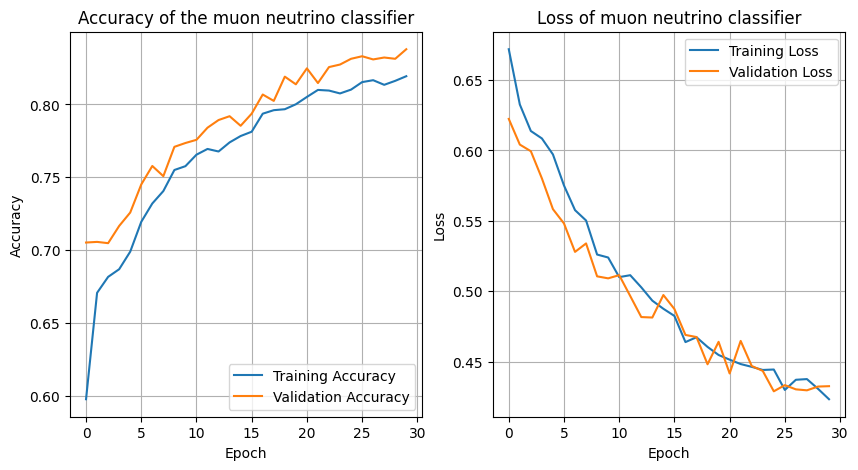

In [ ]:
# accuracy and loss plots
plot_acc_loss(history_low_e)

In [ ]:
test_data = low_e_test_images_xz,  low_e_test_images_yz,  low_e_test_labels
plot_roc_curve(model_le, test_data)

In [ ]:
test_data_le = low_e_test_images_xz,  low_e_test_images_yz,  low_e_test_labels
plot_roc_curve(model_le, low_e_test_images_xz,low_e_test_images_yz, low_e_test_labels)


In [ ]:
train_pred = model_le.predict([low_e_train_images_xz, low_e_train_images_yz])
train_pred_binary = np.round(train_pred)
f1 = f1_score(low_e_test_labels, train_pred_binary, average='binary')
print("F1 score:", f1)
from sklearn.metrics import classification_report


# calculate the classification report
report = classification_report(low_e_test_labels, train_pred_binary)

# print out the precision and recall values
print(report)


## Testing classifier performance on low energy and high energy muons

In [ ]:
files_t2_high_mu=obtaindata(5)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
threshold = 3.5
# Counting how many low energy and high energy muons there are in the dataset
low_e_mu = 0  # Counter for low energy muons
high_e_mu = 0  # Counter for high energy muons

# Iterating over the array of file names to obtain the labels and the input images for each interaction
for file_name in tqdm(files_t2_high_mu):

    # Opening the file in read-only mode
    with h5py.File(file_name, 'r') as f:

        # Counting the number of low and high energy muons in the file
        low_e_mu += ((f['neutrino']['interaction'][:] <= 3) & (f['neutrino']['nuenergy'][:] <= threshold)).sum()
        high_e_mu += ((f['neutrino']['interaction'][:] <= 3) & (f['neutrino']['nuenergy'][:] > threshold)).sum()


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# PRINTING THE NUMBER OF HIGH AND LOW ENERGY MUON EVENTS AND THEIR CORRESPONDING PERCENTAGES

print("Number of high energy muon events:", high_e_mu)
print("Number of low energy muon events:", low_e_mu)

print("Percentage of high energy muons in", len(files_t2_high_mu), "files:", "{:.2f}".format(high_e_mu / (high_e_mu + low_e_mu)*100), "%")
print("Percentage of low energy neutrinos in", len(files_t2_high_mu), "files: " "{:.2f}".format(low_e_mu / (high_e_mu + low_e_mu)*100), "%")


Number of high energy muon events: 19908
Number of low energy muon events: 10785
Percentage of high energy muons in 5 files: 64.86 %
Percentage of low energy neutrinos in 5 files: 35.14 %


In [ ]:

## RETRIEVING THE FILES FOR THIS TASK

files_80_high_mu, files_20_high_mu = train_test_split(files_t2_high_mu, train_size = 0.8, shuffle = False)

In [ ]:
# Initialize empty arrays to store labels and input images
high_mu_labels = []
high_mu_xz_images = []
high_mu_yz_images = []

# Iterate over high energy muon files
for file in tqdm(files_t2_high_mu):

    # Open file in read-only mode
    data = h5py.File(file, 'r')

    # Iterate over neutrino interactions in the file
    for i in range(len(data['neutrino']['interaction'])):

        # Check if the interaction is a non-muon neutrino CC event
        if (data['neutrino']['interaction'][i]) > 3:

            # Reshape the images and append them to the corresponding array
            images = (data['cvnmap'][i]).reshape((2,100,80))
            high_mu_xz_images.append(images[0])
            high_mu_yz_images.append(images[1])

            # Append the label for non-muon neutrino CC event
            high_mu_labels.append(0)

# Iterate over low energy muon files
for file in tqdm(files_20_high_mu):

    # Open file in read-only mode
    data = h5py.File(file, 'r')

    # Iterate over neutrino interactions in the file
    for i in range(len(data['neutrino']['interaction'])):

        # Check if the interaction is a muon neutrino CC event
        if (data['neutrino']['interaction'][i]) <= 3:

            # Classify muons with energy above the threshold
            if (data['neutrino']['nuenergy'][i]) > threshold:

                # Reshape the images and append them to the corresponding array
                images = (data['cvnmap'][i]).reshape((2,100,80))
                high_mu_xz_images.append(images[0])
                high_mu_xz_images.append(images[1])

                # Append the label for muon neutrino CC event
                high_mu_labels.append(1)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Initialize empty arrays to store labels and input images
high_mu_labels = []
high_mu_xz_images = []
high_mu_yz_images = []

# Iterate over high energy muon files
for file in tqdm(files_t2_high_mu):

    # Open file in read-only mode
    data = h5py.File(file, 'r')

    # Iterate over neutrino interactions in the file
    for i in range(len(data['neutrino']['interaction'])):

        # Check if the interaction is a non-muon neutrino CC event
        if (data['neutrino']['interaction'][i]) > 3:

            # Reshape the images and append them to the corresponding array
            images = (data['cvnmap'][i]).reshape((2,100,80))
            high_mu_xz_images.append(images[0])
            high_mu_yz_images.append(images[1])

            # Append the label for non-muon neutrino CC event
            high_mu_labels.append(0)

# Iterate over low energy muon files
for file in tqdm(files_20_high_mu):

    # Open file in read-only mode
    data = h5py.File(file, 'r')

    # Iterate over neutrino interactions in the file
    for i in range(len(data['neutrino']['interaction'])):

        # Check if the interaction is a muon neutrino CC event
        if (data['neutrino']['interaction'][i]) <= 3:

            # Classify muons with energy above the threshold
            if (data['neutrino']['nuenergy'][i]) > threshold:

                # Reshape the images and append them to the corresponding array
                images = (data['cvnmap'][i]).reshape((2,100,80))
                high_mu_xz_images.append(images[0])
                high_mu_yz_images.append(images[1])

                # Append the label for muon neutrino CC event
                high_mu_labels.append(1)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# shuffling the labels and images
high_mu_labels, high_mu_xz_images, high_mu_yz_images = shuffle_img_lbl(high_mu_labels, high_mu_xz_images, high_mu_yz_images)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
high_mu_xz_images = tf.expand_dims(high_mu_xz_images, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
high_mu_yz_images = tf.expand_dims(high_mu_yz_images, axis = 3)

# preparing the training, testing and validation data
high_mu_train_images_xz, high_mu_test_images_xz, high_mu_val_images_xz, high_mu_train_images_yz, high_mu_test_images_yz, high_mu_val_images_yz, high_mu_train_labels, high_mu_val_labels, high_mu_test_labels = prepare_data(high_mu_xz_images, high_mu_yz_images, high_mu_labels, 0.8, 0.8)


In [ ]:

## CREATING THE MODEL FOR ELECTRON NEUTRINO CLASSIFICATION

model_high_mu = concatenating(high_mu_xz_images)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 100, 80, 8)   80          ['input_7[0][0]']                
                                                                                            

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

history_high_mu = model_high_mu.fit(x=[high_mu_train_images_xz,high_mu_train_images_yz],
                    y=high_mu_train_labels, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([high_mu_val_images_xz,high_mu_val_images_yz],high_mu_val_labels),
                    callbacks =[earlystopping] )                                   # used to avoid overtraining


Epoch 1/50
80/80 [==============================] - 4s 22ms/step - loss: 0.6524 - accuracy: 0.6002 - val_loss: 0.5520 - val_accuracy: 0.7464
Epoch 2/50
80/80 [==============================] - 1s 13ms/step - loss: 0.5802 - accuracy: 0.7117 - val_loss: 0.5203 - val_accuracy: 0.7567
Epoch 3/50
80/80 [==============================] - 1s 13ms/step - loss: 0.5683 - accuracy: 0.7115 - val_loss: 0.5205 - val_accuracy: 0.7717
Epoch 4/50
80/80 [==============================] - 1s 13ms/step - loss: 0.5522 - accuracy: 0.7265 - val_loss: 0.5187 - val_accuracy: 0.7551
Epoch 5/50
80/80 [==============================] - 1s 13ms/step - loss: 0.5434 - accuracy: 0.7261 - val_loss: 0.5053 - val_accuracy: 0.7757
Epoch 6/50
80/80 [==============================] - 1s 14ms/step - loss: 0.5352 - accuracy: 0.7269 - val_loss: 0.5004 - val_accuracy: 0.7749
Epoch 7/50
80/80 [==============================] - 1s 14ms/step - loss: 0.5354 - accuracy: 0.7316 - val_loss: 0.5002 - val_accuracy: 0.7780
Epoch 8/50
80

In [ ]:

## EVALUATING THE ACCURACY AND LOSS OF THE MODEL

high_mu_test_loss, high_mu_test_acc = model_high_mu.evaluate([high_mu_test_images_xz,high_mu_test_images_yz,], high_mu_test_labels, verbose=2)



50/50 - 0s - loss: 0.4306 - accuracy: 0.8034 - 350ms/epoch - 7ms/step


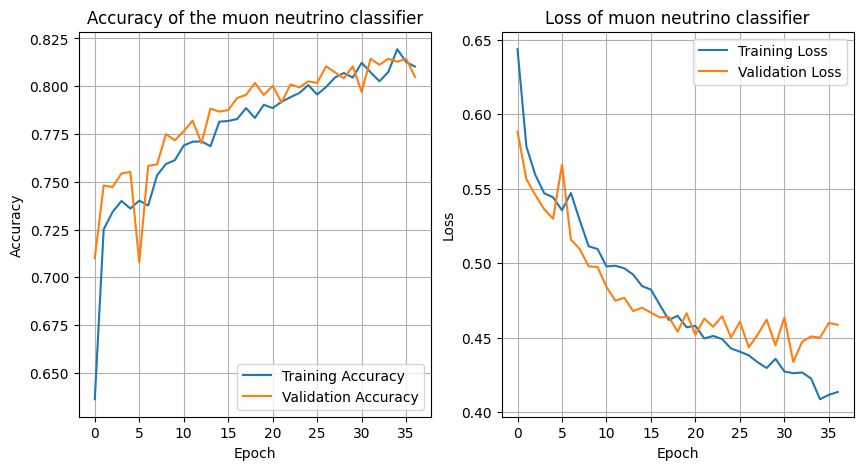

In [ ]:
plot_acc_loss(history_high_mu)

50/50 [==============================] - 0s 3ms/step


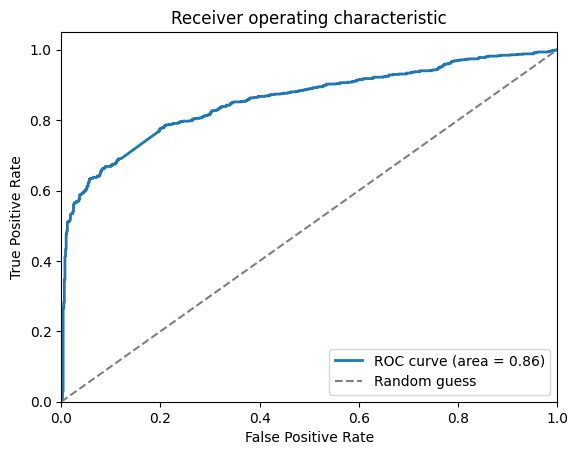

In [ ]:
test_data_high_mu = high_mu_test_images_xz,  high_mu_test_images_xz,  high_mu_test_labels
plot_roc_curve(model_high_mu, test_data_high_mu)


159/159 [==============================] - 0s 2ms/step


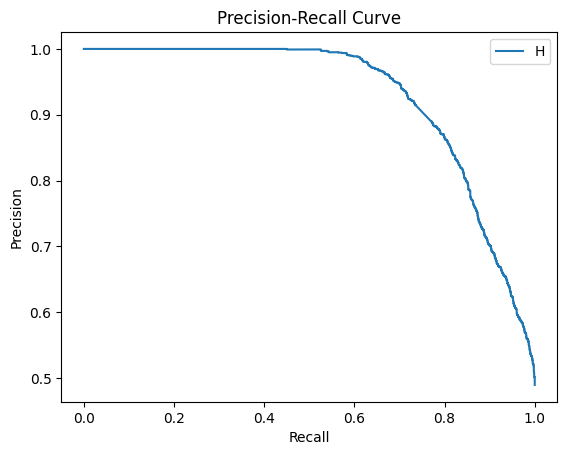

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# generate predictions for the test dataset
y_pred = model_high_mu.predict([high_mu_train_images_xz, high_mu_train_images_yz])

# calculate precision and recall for different thresholds
precision_high_mu, recall_high_mu, thresholds = precision_recall_curve(high_mu_train_labels, y_pred)

# plot the precision-recall curve
plt.plot(recall_high_mu, precision_high_mu)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend('High energy muons')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
train_pred = model_high_mu.predict([high_mu_train_images_xz, high_mu_train_images_yz])
train_pred_binary = np.round(train_pred)
f1 = f1_score(high_mu_train_labels, train_pred_binary, average='binary')
print("F1 score:", f1)
from sklearn.metrics import classification_report


# calculate the classification report
report = classification_report(high_mu_train_labels, train_pred_binary)

# print out the precision and recall values
print(report)


159/159 [==============================] - 1s 3ms/step
F1 score: 0.8058426966292135
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85      2592
         1.0       0.90      0.73      0.81      2468

    accuracy                           0.83      5060
   macro avg       0.84      0.83      0.83      5060
weighted avg       0.84      0.83      0.83      5060



### Testing classifier for low energy muons

In [ ]:

## RETRIEVING THE FILES FOR THIS TASK

files_t2_low_mu=obtaindata(5)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:

## SPLITTING THE IMPORTED FILES

files_80_low_mu, files_20_low_mu = train_test_split(files_t2_low_mu, train_size = 0.7, shuffle = False)

In [ ]:
threshold = 3.5

In [ ]:
## LABELS FOR BINARY CLASSIFICATION FOR MUON NEUTRINO CLASSIFICATION
## BEING PERFORMED ON A DATASET OF LOW ENERGY MUONS
## BALANCING OUT THE MUON NEUTRINO CC EVENTS AND NON-MUON NEUTRINO CC EVENTS

low_mu_labels = []
low_mu_xz_images = []
low_mu_yz_images = []

# iterating over the array of file names to obtain the lables and the input images for each interaction
for filename in tqdm(files_t2_low_mu):

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction
  for i in range(len(df['neutrino']['interaction'])):

    if (df['neutrino']['interaction'][i]) > 3:                        # interactions below or equal 3 are muon neutrino CC events

        model = (df['cvnmap'][i]).reshape((2,100,80))                 # reshaping the images
        low_mu_xz_images.append(model[0])                          # apending the x-z view to the corresponding array
        low_mu_yz_images.append(model[1])                         # apending the y-z view to the corresponding array
        low_mu_labels.append(int(0))                             # 0 for non muon neutrino CC events

    else:
      pass

# iterating over the array of file names to obtain the lables and the input images for each interaction
for filename in tqdm(files_20_low_mu):

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction
  for j in range(len(df['neutrino']['interaction'])):

    if (df['neutrino']['interaction'][j]) <=3:                        # interactions below or equal 3 are muon neutrino CC events

      # classifying muons with energy above the threshold
      if (df['neutrino']['nuenergy'][j]) < threshold:

        model = (df['cvnmap'][j]).reshape((2,100,80))                 # reshaping the images
        low_mu_xz_images.append(model[0])                          # apending the x-z view to the corresponding array
        low_mu_yz_images.append(model[1])                          # apending the y-z view to the corresponding array
        low_mu_labels.append(int(1))                             # 1 for muon neutrino CC events

      else:
        pass

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# shuffling the labels and images
low_mu_labels, low_mu_xz_images, low_mu_yz_images = shuffle_img_lbl(low_mu_labels, low_mu_xz_images, low_mu_yz_images)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
low_mu_xz_images = tf.expand_dims(low_mu_xz_images, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
low_mu_yz_images = tf.expand_dims(low_mu_yz_images, axis = 3)

# preparing the training, testing and validation data
low_mu_train_images_xz, low_mu_test_images_xz, low_mu_val_images_xz, low_mu_train_images_yz, low_mu_test_images_yz, low_mu_val_images_yz, low_mu_train_labels, low_mu_val_labels, low_mu_test_labels = prepare_data(low_mu_xz_images, low_mu_yz_images, low_mu_labels, 0.8, 0.8)


In [ ]:

## CREATING THE MODEL FOR ELECTRON NEUTRINO CLASSIFICATION

model_low_mu = concatenating(low_mu_xz_images)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 80, 8)   80          ['input_3[0][0]']                
                                                                                            

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

history_low_mu = model_low_mu.fit(x=[low_mu_train_images_xz,low_mu_train_images_yz],
                    y=low_mu_train_labels, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([low_mu_val_images_xz,low_mu_val_images_yz],low_mu_val_labels),
                    callbacks =[earlystopping] )                                   # used to avoid overtraining


Epoch 1/50
84/84 [==============================] - 6s 22ms/step - loss: 0.6708 - accuracy: 0.5621 - val_loss: 0.6110 - val_accuracy: 0.6709
Epoch 2/50
84/84 [==============================] - 1s 13ms/step - loss: 0.6292 - accuracy: 0.6377 - val_loss: 0.5884 - val_accuracy: 0.6957
Epoch 3/50
84/84 [==============================] - 1s 13ms/step - loss: 0.6165 - accuracy: 0.6604 - val_loss: 0.5733 - val_accuracy: 0.7166
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.5992 - accuracy: 0.6778 - val_loss: 0.5560 - val_accuracy: 0.7226
Epoch 5/50
84/84 [==============================] - 1s 13ms/step - loss: 0.5903 - accuracy: 0.6864 - val_loss: 0.5595 - val_accuracy: 0.7309
Epoch 6/50
84/84 [==============================] - 1s 13ms/step - loss: 0.5788 - accuracy: 0.6988 - val_loss: 0.5415 - val_accuracy: 0.7376
Epoch 7/50
84/84 [==============================] - 1s 13ms/step - loss: 0.5708 - accuracy: 0.7098 - val_loss: 0.5311 - val_accuracy: 0.7331
Epoch 8/50
84

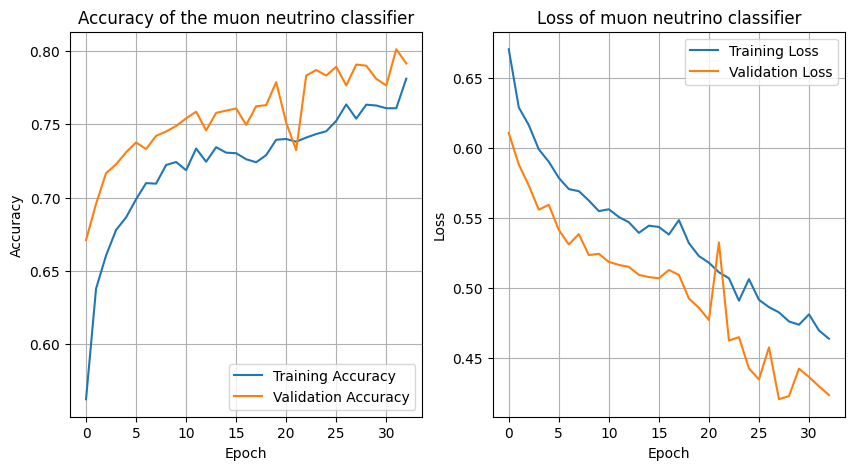

In [ ]:
plot_acc_loss(history_low_mu)

The accuracy and loss plots once again show good performance with small fluctuations.

180/180 [==============================] - 1s 3ms/step


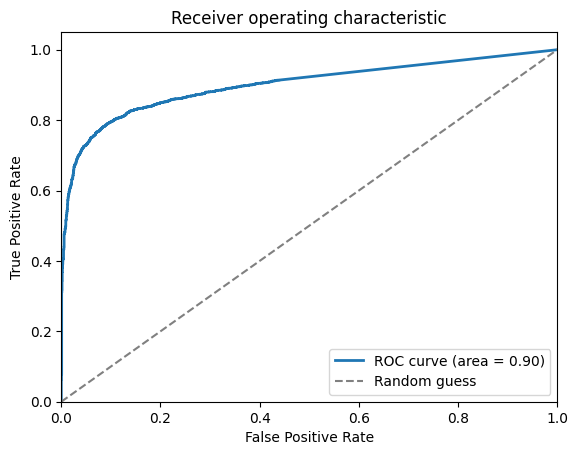

In [ ]:
model = model_low_mu
test_data = (low_mu_train_images_xz, low_mu_train_images_yz, low_mu_train_labels)

plot_roc_curve(model, test_data)

The AUC value of 0.9 is quite high, confirming the optimal performance of the model on this dataset.

53/53 [==============================] - 0s 3ms/step


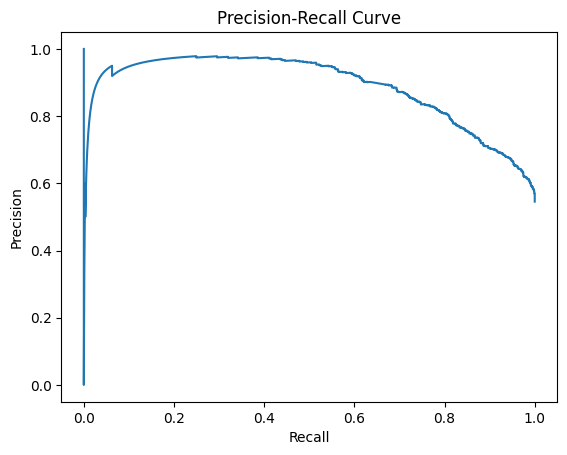

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# generate predictions for the test dataset
y_pred = model_low_mu.predict([low_mu_test_images_xz, low_mu_test_images_yz])

# calculate precision and recall for different thresholds
precision_low_mu, recall_low_mu, thresholds = precision_recall_curve(low_mu_test_labels, y_pred)

# plot the precision-recall curve
plt.plot(recall_low_mu, precision_low_mu)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

The precision recall takes a deep drop at a recall value of 0.0 before behaving normally. This could be because the model  is initially classifying a lot of the positive samples as negative, resulting in low recall and precision. Another reason could be the noise in data.

In [ ]:
train_pred = model_low_mu.predict([low_mu_train_images_xz, low_mu_train_images_yz])
train_pred_binary = np.round(train_pred)
f1 = f1_score(low_mu_train_labels, train_pred_binary, average='binary')
print("F1 score:", f1)
from sklearn.metrics import classification_report


# calculate the classification report
report = classification_report(low_mu_train_labels, train_pred_binary)

# print out the precision and recall values
print(report)


167/167 [==============================] - 1s 3ms/step
F1 score: 0.762693935119887
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      2617
         1.0       0.73      0.80      0.76      2718

    accuracy                           0.75      5335
   macro avg       0.75      0.75      0.75      5335
weighted avg       0.75      0.75      0.75      5335



## Which variables in the metadata does the classifier performance depend on?



*   Metadata distribution: There were more instances of some metadata than others, which leads to overrepresentation and underrepresentation. Hence, if the model did not have a fair number of certain files to work with, the accuracy could decrease. This is more applicable if a small number of files were used, although this is necessary in this task due to computational constraints and for time efficiency.


*   CC DIS and CC QE interactions: QE interactions produce simpler and cleaner images, making it easier for the model to classify accurately, thus leading to higher accuracies. On the other had, DIS interactions are messier and more cluttered, making it more difficult for the model to distinguish between the signal and the background noise, leading to a lower accuracy.
*   Energy of the neutrinos and neutrinos: these usually tend to produce brighter and more distinctive tracks in the detector, which are easier for the CNN model to distinguish from the background noise. This results in a more accurate prediction by the model.



# Extensions

## 1. Implementing a machine learning algorithm to determine the energy of a neutrino

To predict the energy of neutrinos from detector images, the classifier was adjusted by
converting the MVCNN model into a regression task, as the input features are mapped to
a continuous output value. The RMSprop optimization technique was employed since it is
highly beneficial for regression models, as it modifies the learning rate for each parameter
by considering the recent history of gradients. Since a multi-view CNN model was already made, it would be efficient to adapt this to a regression model.


In [ ]:

## RETRIEVING THE FILES FOR THIS EXTENSION

files_ex_1 = obtaindata(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:

## PREPARING THE DATA AND LABELS FOR THE MODEL

ex_1_labels=[]                                                      # empty array for the labels of the neutrino energy
ex_1_images_xz=[]                                                     # empty array for the x-z view of the neutrino interaction
ex_1_images_yz=[]                                                     # empty array for the y-z view of the neutrino interaction

# iterating over the array of file names to obtain the lables and the input images for each interaction
for filename in tqdm(files_ex_1):

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction
  for i in range(len(df['cvnmap'])):

    model = df['cvnmap'][i].reshape((2,100,80))                           # reshaping the images
    ex_1_images_xz.append(model[0])                                    # apending the x-z view to the corresponding array
    ex_1_images_yz.append(model[1])                                    # apending the y-z view to the corresponding array
    ex_1_labels.append(int(df['neutrino']['nuenergy'][i]))           # appending the value of the energy to the labels



  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
ex_1_images_xz = tf.expand_dims(ex_1_images_xz, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
ex_1_images_yz = tf.expand_dims(ex_1_images_yz, axis = 3)

# normalizing the energy labels
nu_energy_labels=ex_1_labels/np.max(ex_1_labels)

# preparing the training, testing and validation data
train_input_xz_ex1, test_input_xz_ex1, val_input_xz_ex1, train_input_yz_ex1, test_input_yz_ex1, val_input_yz_ex1, train_labels_ex1, val_labels_ex1, test_labels_ex1 = prepare_data(ex_1_images_xz, ex_1_images_yz, ex_1_labels, 0.8, 0.8)


A new model has been defined that is more complex than the Multi-View CNN model used earlier. This model has more convolutional layers, dropout layers, and fully connected layers. It also takes two inputs, while the second model takes only one input.

In [ ]:
# Define regression model
def regression_model(model_input_1):

    # Define the inputs
    first_input = Input(shape=(100, 80, 1), name='first_input')
    second_input = Input(shape=(100, 80, 1), name='second_input')

    # Define the convolutional layers for the first input
    conv1_1 = Conv2D(128, (3, 3), activation='relu')(first_input)
    pool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
    dropout1_1 = Dropout(0.30)(pool1_1)

    conv1_2 = Conv2D(16, (3, 3), activation='relu')(dropout1_1)
    pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
    dropout1_2 = Dropout(0.30)(pool1_2)

    conv1_3 = Conv2D(16, (3, 3), activation='relu')(dropout1_2)
    pool1_3 = MaxPooling2D(pool_size=(2, 2))(conv1_3)
    dropout1_3 = Dropout(0.30)(pool1_3)

    # Define the convolutional layers for the second input
    conv2_1 = Conv2D(64, (3, 3), activation='relu')(second_input)
    pool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    dropout2_1 = Dropout(0.30)(pool2_1)

    conv2_2 = Conv2D(16, (3, 3), activation='relu')(dropout2_1)
    pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
    dropout2_2 = Dropout(0.30)(pool2_2)

    conv2_3 = Conv2D(16, (3, 3), activation='relu')(dropout2_2)
    pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_3)
    dropout2_3 = Dropout(0.30)(pool2_3)

    # Concatenate the output of the convolutional layers
    merged = Concatenate()([dropout1_3, dropout2_3])

    # Flatten the output
    flatten = Flatten()(merged)

    # Define the fully connected layers
    fc1 = Dense(8, activation='relu')(flatten)
    dropout3 = Dropout(0.50)(fc1)
    fc2 = Dense(1, activation='linear')(dropout3)

    # Create the model
    multi_model = Model(inputs=[first_input, second_input], outputs=fc2)

    # Compile the model
    multi_model.compile(loss='mean_squared_error' , optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mean_absolute_error'])

    return multi_model

In [ ]:

model_input_1 = ex_1_images_xz
regression_model = regression_model(model_input_1)

regression_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_input (InputLayer)       [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 second_input (InputLayer)      [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 98, 78, 128)  1280        ['first_input[0][0]']            
                                                                                            

In [ ]:

## CREATING THE MODEL FOR ENERGY DETERMINATION

model = regression_model(ex_1_images_xz)

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

history_ex1 = regression_model.fit(x=[train_input_xz_ex1, train_input_yz_ex1],
                    y= train_labels_ex1, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([val_input_xz_ex1, val_input_yz_ex1],val_labels_ex1),
                    callbacks =[earlystopping] )                                   # used to avoid overtraining


Epoch 1/50
348/348 [==============================] - 34s 60ms/step - loss: 123.3525 - mean_absolute_error: 7.9461 - val_loss: 108.6086 - val_mean_absolute_error: 6.9506
Epoch 2/50
348/348 [==============================] - 19s 56ms/step - loss: 114.7156 - mean_absolute_error: 7.6409 - val_loss: 91.0523 - val_mean_absolute_error: 6.8735
Epoch 3/50
348/348 [==============================] - 20s 56ms/step - loss: 112.9237 - mean_absolute_error: 7.5806 - val_loss: 101.5737 - val_mean_absolute_error: 6.9116
Epoch 4/50
348/348 [==============================] - 19s 55ms/step - loss: 110.9823 - mean_absolute_error: 7.5252 - val_loss: 98.3791 - val_mean_absolute_error: 6.8434
Epoch 5/50
348/348 [==============================] - 19s 55ms/step - loss: 108.6848 - mean_absolute_error: 7.4619 - val_loss: 91.3141 - val_mean_absolute_error: 6.8563
Epoch 6/50
348/348 [==============================] - 19s 56ms/step - loss: 109.0101 - mean_absolute_error: 7.4333 - val_loss: 91.9202 - val_mean_absolut

Text(0.5, 1.0, 'MAE of the model to determine neutrino energy')

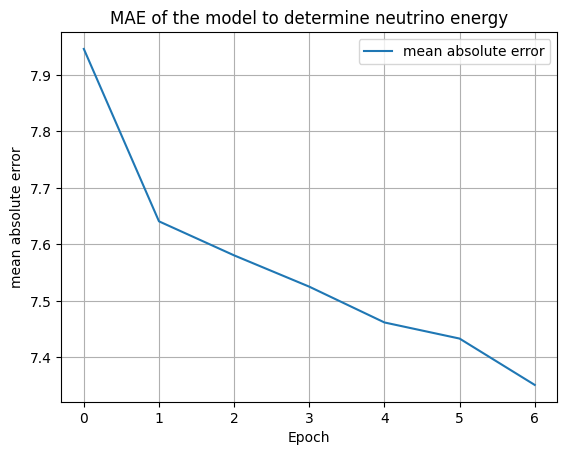

In [ ]:
 ## PLOTTING THE MAE OF THE MODEL

plt.plot(history_ex1.history['mean_absolute_error'], label='mean absolute error')
plt.xlabel('Epoch')
plt.ylabel('mean absolute error')
plt.legend(loc='upper right')
plt.grid()
plt.title('MAE of the model to determine neutrino energy')

The MAE is shown to decrease with a higher number of epochs, indicating better model performance. The MAE decreases more steeply from 0 to 1 epochs and from 5 to 6 epochs than it does from 1 to 5 epochs. The MAE seems to have decreased from 7.95 to 7.35, which is an acceptable difference.


## Extension 2: Creating a machine learning algorithm to determine the flavour of the neutrino

In [ ]:
files_ex2 = obtaindata(15)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
## SPLITTING THE FILES

files_ex2_99, files_ex2_01 = train_test_split(files_ex2, train_size = 0.99)
files_ex2_90, files_ex2_10 = train_test_split(files_ex2, train_size = 0.90)

In [ ]:

# Create empty arrays to store the labels and input images for each interaction
ex2_labels = []
ex2_images_xz = []
ex2_images_yz = []

# Iterate over files with muon neutrinos (interactions between 0 and 3)
for filename in tqdm(files_ex2_01 ):
    with h5py.File(filename, 'r') as f:  # Use 'with' statement to automatically close the file after iteration
        for i in range(len(f['neutrino']['interaction'])):
            if f['neutrino']['interaction'][i] <= 3:
                model = f['cvnmap'][i].reshape((2, 100, 80))
                ex2_images_xz.append(model[0])
                ex2_images_yz.append(model[1])
                ex2_labels.append(1)  # Append 1 for muon neutrinos

# Iterate over files with electron neutrinos (interactions between 4 and 7)
for filename in tqdm(files_ex2):
    with h5py.File(filename, 'r') as f:
        for j in range(len(f['neutrino']['interaction'])):
            if 4 <= f['neutrino']['interaction'][j] <= 7:
                model = f['cvnmap'][j].reshape((2, 100, 80))
                ex2_images_xz.append(model[0])
                ex2_images_yz.append(model[1])
                ex2_labels.append(2)  # Append 2 for electron neutrinos



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:

## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# shuffling the labels and images
ex2_labels, ex2_images_xz, ex2_images_yz = shuffle_img_lbl(ex2_labels, ex2_images_xz, ex2_images_yz)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
ex2_images_xz = tf.expand_dims(ex2_images_xz, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
ex2_images_yz = tf.expand_dims(ex2_images_yz, axis = 3)

# preparing the training, testing and validation data
train_images_xz_ex2, test_images_xz_ex2, val_images_xz_ex2, train_images_yz_ex2, test_images_yz_ex2, val_images_yz_ex2, train_labels_ex2, val_labels_ex2, test_labels_ex2 = prepare_data(ex2_images_xz, ex2_images_yz, ex2_labels, 0.8, 0.8)

# to be able to use categorical cross entropy
train_labels_ex2 = tf.keras.utils.to_categorical(train_labels_ex2, 3)
test_labels_ex2 = tf.keras.utils.to_categorical(test_labels_ex2, 3)
val_labels_ex2 = tf.keras.utils.to_categorical(val_labels_ex2, 3)

In [ ]:

def create_convolution_layers2(input_img, input_shape):

  """
  This function creates a simple Convolutional Neural Network model in keras using the functional API.

  Input:
  - input_img: image to be fed into the network, either the x-z view of the interaction or the y-z view.
  - input_shape: shape of the images being fed into the network.

  Output:
  - model: CNN model

  """
  # releases the global state and helps avoid clutter from other models
  #keras.backend.clear_session


  # Conv2D layer is used for images.
  model = Conv2D(64, (3, 3),                                                     # Using a filter size of 8, kernel size of (3,3)
                 activation = "relu",                                           # Rectified Linear Unit as activation function
                 padding='same', input_shape=input_shape[1:])(input_img)        # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  # Regularization technique for the model
  model = Dropout(0.25)(model)                                                  # 25% of the data is randomly excluded


  # Conv2D layer is used for images.
  model = Conv2D(64, (3, 3),                                                    # Using a filter size of 16, kernel size of (3,3)
                 padding='same')(model)                                         # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  model = Dropout(0.25)(model)                                                  # 25% of the data is randomly excluded

  # Conv2D layer is used for images.
  model = Conv2D(64, (3, 3),                                                    # Using a filter size of 32, kernel size of (3,3)
                 padding='same')(model)                                         # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  model = Dropout(0.4)(model)                                                   # 40% of the data is randomly excluded

  return model


In [ ]:
def model_ex2():
  # Creates the CNN model for the x-z view of the neutrino interaction.
  xz_input = Input(shape=np.shape(ex2_images_xz)[1:])
  xz_model = create_convolution_layers2(xz_input, np.shape(ex2_images_xz)[1:])

  # Creates the CNN model for the y-z view of the neutrino interaction.
  yz_input = Input(shape=np.shape(ex2_images_xz)[1:])
  yz_model = create_convolution_layers2(yz_input, np.shape(ex2_images_xz)[1:])

  # Concatenates the two models
  conv = concatenate([xz_model, yz_model])

  # Flattens the concatenated models
  conv = Flatten()(conv)

  # Dense layers connect all the neurons of one layer to the ones in the next layer
  dense = Dense(64,                                                              # 64 is the dimensionality of the output space
                activation = "relu")(conv)                                      # Rectified Linear Unit as activation function
  dense = Dropout(0.5)(dense)                                                   # 50% of the data is randomly excluded

  output = Dense(3,                                                             # 1 is the dimensionality of the output space
                  activation ="softmax")(dense)                                  # sigmoid as activation function.
                                                                                # The input to the function is transformed into a value between 0.0 and 1.0.

  # creates the model using the two model inputs
  model = Model(inputs = [xz_input, yz_input], outputs = [output])

  # compiles the final model
  model.compile(loss=tf.keras.losses.categorical_crossentropy,                       # using cateogircal crossentropy as a loss function as we are doing a binary classification
  # adam is used for optimization algorithm for stochastic gradient descent for training deep learning models
                optimizer='adam',
                metrics=['accuracy'])                                           # using the accuracy as a metric to evaluate the model

  return model


model = model_ex2()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 80, 64)  640         ['input_3[0][0]']                
                                                                                            

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       # quantity to be monitored
                                        mode ="min",                               # training will stop when val_loss is at its minimum
                                        patience = 5,                              # number of epochs with no improvement after which training will be stopped
                                        restore_best_weights = True)               # restore to the val_loss of the first epoch from which there is no improvement

history_ex2 = model.fit(x=[train_images_xz_ex2, train_images_yz_ex2],
                    y= train_labels_ex2, batch_size=64,                                 # number of training examples utilized in one iteration
                    epochs=50,                                                     # 1 epoch: when the entire dataset is passed forward and backward through the CNN
                    validation_data=([val_images_xz_ex2, val_images_yz_ex2],val_labels_ex2),
                    callbacks =[earlystopping] )                                   # used to avoid overtraining


Epoch 1/50
73/73 [==============================] - 9s 68ms/step - loss: 0.5341 - accuracy: 0.8179 - val_loss: 0.3933 - val_accuracy: 0.8442
Epoch 2/50
73/73 [==============================] - 4s 55ms/step - loss: 0.4260 - accuracy: 0.8398 - val_loss: 0.3797 - val_accuracy: 0.8511
Epoch 3/50
73/73 [==============================] - 4s 55ms/step - loss: 0.4158 - accuracy: 0.8467 - val_loss: 0.3556 - val_accuracy: 0.8606
Epoch 4/50
73/73 [==============================] - 4s 55ms/step - loss: 0.4009 - accuracy: 0.8476 - val_loss: 0.3573 - val_accuracy: 0.8640
Epoch 5/50
73/73 [==============================] - 4s 55ms/step - loss: 0.3830 - accuracy: 0.8504 - val_loss: 0.3577 - val_accuracy: 0.8632
Epoch 6/50
73/73 [==============================] - 4s 55ms/step - loss: 0.3697 - accuracy: 0.8527 - val_loss: 0.3308 - val_accuracy: 0.8640
Epoch 7/50
73/73 [==============================] - 4s 55ms/step - loss: 0.3518 - accuracy: 0.8512 - val_loss: 0.3178 - val_accuracy: 0.8640
Epoch 8/50
73

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, test_images1, test_images2, test_labels):
    # generate predictions for the test dataset
    y_pred = model.predict([test_images1, test_images2])

    # calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(test_labels[:, 1], y_pred[:, 1])

    # plot the precision-recall curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()


In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL

test_loss_ex2, test_acc_ex2 = model.evaluate([test_images_xz_ex2, test_images_yz_ex2],  test_labels_ex2, verbose=2)


46/46 - 1s - loss: 0.2756 - accuracy: 0.8671 - 708ms/epoch - 15ms/step


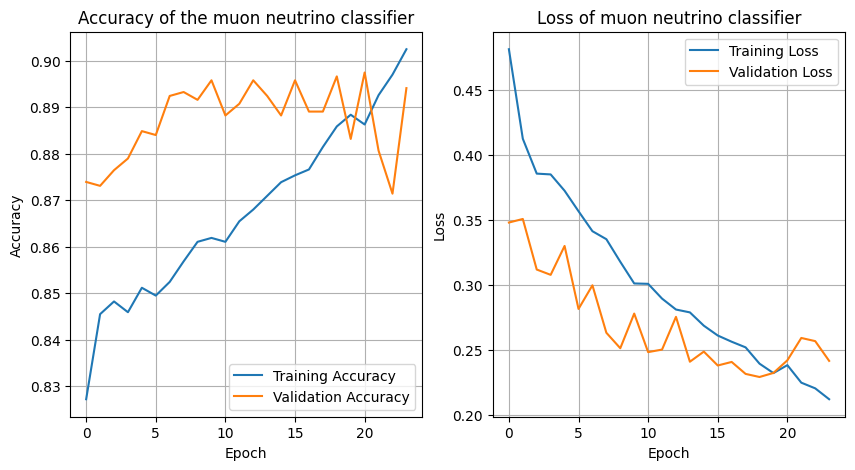

In [ ]:
plot_acc_loss(history_ex2)

46/46 [==============================] - 0s 5ms/step


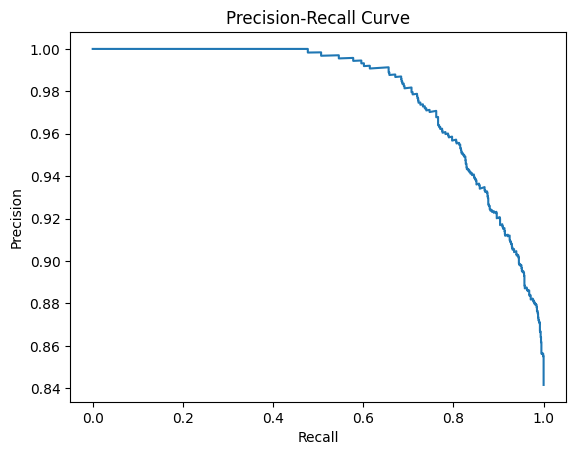

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# generate predictions for the test dataset
y_pred = model.predict([test_images_xz_ex2, test_images_yz_ex2])

# calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(test_labels_ex2[:, 1], y_pred[:, 1])

# plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## Creating more plots for the report

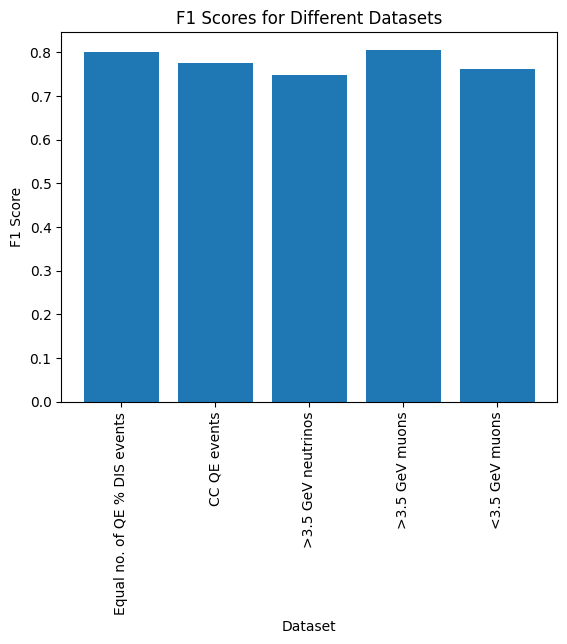

In [ ]:
import matplotlib.pyplot as plt

# Define the dataset and F1 score
dataset = ['Equal no. of QE % DIS events', 'CC QE events', '>3.5 GeV neutrinos', '>3.5 GeV muons', '<3.5 GeV muons']
f1_score = [0.8008485813, 0.7748076144, 0.7491556647, 0.8058426966, 0.7626939351]

# Create a vertical bar chart
plt.bar(dataset, f1_score)

# Rotate the x-axis labels
plt.xticks(rotation='vertical')

# Add axis labels and a title
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Datasets')

# Show the plot
plt.show()


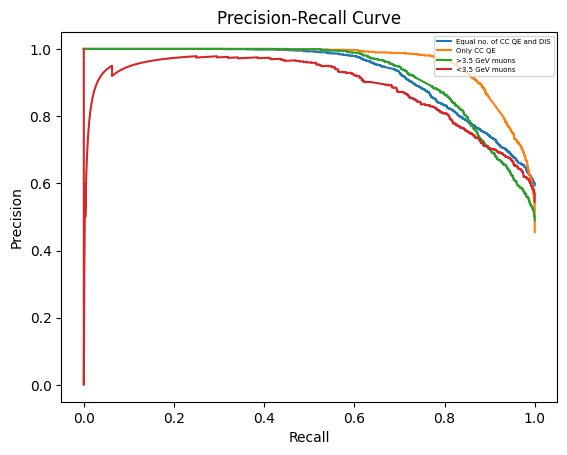

In [ ]:
# Combining precision recall curves

plt.plot(recall_disqe_eq, precision_disqe_eq, label='Equal no. of CC QE and DIS')
plt.plot(recall_qe, precision_qe, label='Only CC QE')
plt.plot(recall_high_mu, precision_high_mu, label='>3.5 GeV muons')
plt.plot(recall_low_mu, precision_low_mu, label='<3.5 GeV muons')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(fontsize='5', loc='upper right')
plt.show()

## Conclusion

In this project, two variations of a CNN model were made with the Multi-View CNN model chosen as the most effective for this project, due to its accuracy of 0.8437 and loss of 0.4217. The model was trained on several images, similar to those detected by the NOvA experiment, to classify neutrinos in a long-baseline neutrino oscillation experiment. Various datasets were testing using this model, including DIS, QE, low and high energy neutrinos and muons (resulting in accuracies more than 0.80) and well-performing accuracy and loss plots, ROC and precision-recall curves. As extended investigations, the MVCNN was modified as a regression task
 to determine the energy, flavour and interaction mode of the neutrino and the lepton energy over the neutrino energy.

Further improvements to the model could include attention mechanisms, proposed by Mnih et al, which highlight important features or regions in the input images, thus improving the interpretability and accuracy of the model [21]. Additionally, transfer learning can be used to utilise pre-trained models on large datasets, such as ImageNet [22-23]. A comprehensive understanding of the fundamental properties and behaviours of neutrinos strengthens our understanding of various astronomical phenomena such as gamma-ray bursts and black hole mergers, the mass hierarchy problem and supersymmetry and developing new physics beyond the scope of the Standard Model [25-28]. Study of the neutrinos is also essential for fundamental research and practical applications such as geology. For example, neutrinos can provide information about the Earth's composition, as well as insights into the workings of the sun and other stars [24].

In terms of computational constraints, a system with a higher RAM and better performing GPU would significantly reduce the time required to obtain files and train models, thereby increasing overall efficiency. This would be useful in determining interaction mode and the number of protons and pions, hence extending the scope of further investigations. The Multi-View CNN Model could also be used in geological and astrophysical applications with the appropriate datasets.

# References

[1] What is a neutrino? Scientific American 1999. https://www.scientificamerican.com/article/what-is-a-neutrino/


[2] Baird M, Bian J, Messier M, Niner E, Rocco D, Sachdev K. Event Reconstruction Techniques in NOvA. Journal of Physics: Conference Series 2015;664:072035. https://doi.org/10.1088/1742-6596/664/7/072035.
‌

[3] What are Neural Networks? | IBM. Ibmcom 2021. https://www.ibm.com/topics/neural-networks
‌

[4] Psihas F, Groh M, Tunnell C, Warburton K. A review on machine learning for neutrino experiments. International Journal of Modern Physics A 2020;35:2043005. https://doi.org/10.1142/s0217751x20430058.

‌
[5] Aurisano A, Radovic A, Rocco D, Himmel A, Messier MD, Niner E, et al. A convolutional neural network neutrino event classifier. Journal of Instrumentation 2016;11:P09001–1. https://doi.org/10.1088/1748-0221/11/09/p09001.
‌

[6] Patrick C., Nichol R., FAQ for neutrino oscillation. https://moodle.ucl.ac.uk/pluginfile.php/5982518/mod_resource/content/5/FAQ_for__PHAS0056_Neutrino_Interactions_mini_project.pdf
‌

[7] Deep Inelastic Scattering of Electrons. Gsuedu 2023. http://hyperphysics.phy-astr.gsu.edu/hbase/Nuclear/scatele.html
‌

[8] INSPIRE. Inspirehepnet 2023. https://inspirehep.net/literature/774999
‌

[9] How does NOvA work? | NOvA. Fnalgov 2023. https://novaexperiment.fnal.gov/how-does-nova-work/ (accessed March 26, 2023).
‌

[10] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 15(1), 1929-1958. https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf


[11] Ng, A. (2004). Feature selection, L1 vs. L2 regularization, and rotational invariance. In Proceedings of the Twenty-First International Conference on Machine Learning (pp. 78-85). https://dl.acm.org/doi/10.1145/1015330.1015435


[12] Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In Proceedings of the 32nd International Conference on Machine Learning (pp. 448-456). https://proceedings.mlr.press/v37/ioffe15.pdf


[13] Prechelt, L. (1998). Early stopping-but when? In Neural Networks: Tricks of the Trade (pp. 55-69). Springer. https://link.springer.com/chapter/10.1007/3-540-49430-8\_6


[14] Wan, L., Zeiler, M., Zhang, S., Cun, Y. L., & Fergus, R. (2013). Regularization of neural networks using dropconnect. In Proceedings of the 30th International Conference on Machine Learning (pp. 1058-1066). https://proceedings.mlr.press/v28/wan13.pdf


[15] A. Krizhevsky, I. Sutskever, G.E. Hinton, "ImageNet Classification with Deep Convolutional Neural Networks", Advances in Neural Information Processing Systems 25 (NIPS 2012), (2012). [http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks]


[16] K. Theofilatos et al., "Convolutional Neural Networks Applied to Housekeeping Gene Identification in Eukaryotic Organisms," IEEE/ACM Transactions on Computational Biology and Bioinformatics, (2017). [doi: 10.1109/TCBB.2016.2536254]


[17] D. Scherer, A. Müller, and S. Behnke, "Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition," International Conference on Artificial Neural Networks (ICANN), (2010). [doi: 10.1007/978-3-642-15819-3\_19]


[18] C. Szegedy, W. Liu, Y. Jia, P. Sermanet, S. Reed, D. Anguelov, D. Erhan, V. Vanhoucke, A. Rabinovich, et al., "Going deeper with convolutions," in 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015, pp. 1-9.


[19] Hoo ZH, Candlish J, Teare D. What is an ROC curve? Emergency Medicine Journal 2017;34:357–9. https://doi.org/10.1136/emermed-2017-206735.
‌

[20] Bustamante M. Pushing the Energy and Cosmic Frontiers with High-Energy Astrophysical Neutrinos 1. ResearchGate 2020. Energy\_Astrophysical\_Neutrinos\_1
‌

[21] Recurrent Models of Visual Attention. ResearchGate 2014. https://www.researchgate.net/publication/263390366\_Recurrent\_Models\_of\_Visua\l_Attention (accessed April 5, 2023).
‌

[22] Pan SJ, Yang Q. A Survey on Transfer Learning. IEEE Transactions on Knowledge and Data Engineering 2010;22:1345–59. https://doi.org/10.1109/tkde.2009.191.
‌

[23] Elango V, Patel AN, Miller KJ, Gilja V. Sequence Transfer Learning for Neural Decoding 2017. https://doi.org/10.1101/210732.
‌

[24] Donini A, Palomares-Ruiz S, Salvado J. Neutrino tomography of Earth. Nature Physics 2018;15:37–40. https://doi.org/10.1038/s41567-018-0319-1.
‌

[25] Halzen F, Klein SR. Invited Review Article: IceCube: An instrument for neutrino astronomy. Review of Scientific Instruments 2010;81:081101. https://doi.org/10.1063/1.3480478.


[26] Neutrino Oscillations: A Practical Guide to Basics and Applications | Request PDF. ResearchGate 2015. https://doi.org/10.1007//978-4-431-55462-2.


[27] Qian X, Vogel P. Neutrino mass hierarchy. Progress in Particle and Nuclear Physics 2015;83:1–30. https://doi.org/10.1016/j.ppnp.2015.05.002.


[28] Mukhopadhyaya B. Supersymmetry and neutrino mass. ArXivorg 2023. https://arxiv.org/abs/hep-ph/0301278


[29] The relationship between Precision-Recall and ROC curves | Proceedings of the 23rd international conference on Machine learning. ACM Other Conferences 2023. https://dl.acm.org/doi/10.1145/1143844.1143874
‌

[30] Evaluation: From Precision, Recall and F-Factor to ROC, Informedness, Markedness & Correlation. ResearchGate 2023. \href{https://www.researchgate.net/publication/228529307_Evaluation_From_Precision_Recall_and_F-Factor_to_ROC_Informedness_Markedness_Correlation}
‌

[31] Fawcett T. An introduction to ROC analysis. Pattern Recognition Letters 2006;27:861–74. https://doi.org/10.1016/j.patrec.2005.10.010.
‌